In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import pywt

In [ ]:
import pandas as pd

# Load the data
data_path = '/mnt/data/HW7_dat.csv'
data = pd.read_csv(data_path, header=None, names=['y', 'x'])

# Display the first few rows of the dataset to understand its structure
data.head()

# Correctly load the data, skipping the first row as it contains the column names
data = pd.read_csv(data_path, skiprows=1, header=None, names=['y', 'x'])

# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='blue', label='Original Data Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Original Data')
plt.legend()
plt.grid(True)
plt.show()

import numpy as np

def gaussian_kernel(x, y, sigma=0.5):
    """Gaussian kernel function."""
    return np.exp(-np.linalg.norm(x-y, axis=1)**2 / (2 * sigma**2))

def laplacian_kernel(x, y, sigma=1.0):
    """Laplacian kernel function."""
    return np.exp(-np.linalg.norm(x-y, axis=1) / sigma)

def polynomial_kernel(x, y, degree=2, coef0=1):
    """Polynomial kernel function."""
    return (np.dot(x, y.T) + coef0)**degree

# Test the kernel functions with sample inputs
x_sample = np.array([[0.5]])
y_samples = np.array([[0.5], [1.0], [1.5]])

# Testing
print("Gaussian Kernel:", gaussian_kernel(x_sample, y_samples))
print("Laplacian Kernel:", laplacian_kernel(x_sample, y_samples))
print("Polynomial Kernel:", polynomial_kernel(x_sample, y_samples))

from numpy.linalg import inv

def rkhs_regression(x_train, y_train, kernel_func, lambda_param):
    """
    Perform RKHS regression using the specified kernel function and regularization parameter.
    
    Args:
    - x_train: Training inputs, shape (n_samples, n_features).
    - y_train: Training targets, shape (n_samples,).
    - kernel_func: Kernel function taking two arguments.
    - lambda_param: Regularization parameter.
    
    Returns:
    - A function that takes new input points and returns the predicted values based on the learned model.
    """
    # Compute the kernel matrix
    n_samples = x_train.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_func(x_train[i:i+1], x_train[j:j+1])
    
    # Solve for the coefficients (alpha) in the linear system
    alpha = inv(K + lambda_param * np.eye(n_samples)).dot(y_train)
    
    # Define the function that computes predictions for new inputs
    def predict(x_new):
        # Compute the kernel values between new inputs and training inputs
        K_new = np.array([kernel_func(x_train, x_new[i:i+1]) for i in range(x_new.shape[0])])
        # Predictions are linear combinations of kernel values and coefficients
        return K_new.dot(alpha)
    
    return predict

# Prepare the data
x_train = data['x'].values.reshape(-1, 1)
y_train = data['y'].values

# We'll visualize the regression results in the next steps

# Define the uniform sampling points
x_sampling_points = np.linspace(0, 2, 100).reshape(-1, 1)

# Lambda values to test
lambda_values = [0.01, 0.1, 1, 10, 100]

# Perform regression and plot for Gaussian kernel
plt.figure(figsize=(15, 10))

for i, lambda_val in enumerate(lambda_values, 1):
    # Use the RKHS regression function with Gaussian kernel
    predict_gaussian = rkhs_regression(x_train, y_train, gaussian_kernel, lambda_val)
    predictions = predict_gaussian(x_sampling_points)
    
    # Plot
    plt.subplot(2, 3, i)
    plt.scatter(data['x'], data['y'], color='blue', label='Original Data')
    plt.plot(x_sampling_points, predictions, color='red', label='Predictions')
    plt.title(f'Gaussian Kernel with lambda={lambda_val}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Perform regression and plot for Laplacian kernel
plt.figure(figsize=(15, 10))

for i, lambda_val in enumerate(lambda_values, 1):
    # Use the RKHS regression function with Laplacian kernel
    predict_laplacian = rkhs_regression(x_train, y_train, laplacian_kernel, lambda_val)
    predictions = predict_laplacian(x_sampling_points)
    
    # Plot
    plt.subplot(2, 3, i)
    plt.scatter(data['x'], data['y'], color='blue', label='Original Data')
    plt.plot(x_sampling_points, predictions, color='red', label='Predictions')
    plt.title(f'Laplacian Kernel with lambda={lambda_val}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

from sklearn.model_selection import KFold

def cross_validation_error(x, y, kernel_func, lambda_val, n_splits=5):
    """
    Compute the cross-validation error for a given lambda and kernel function.
    
    Args:
    - x: Input features.
    - y: Target values.
    - kernel_func: Kernel function to use in regression.
    - lambda_val: The regularization parameter lambda.
    - n_splits: Number of folds in K-Fold cross-validation.
    
    Returns:
    - Mean squared error across all folds.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    errors = []
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model
        predict = rkhs_regression(x_train, y_train, kernel_func, lambda_val)
        # Predict on the test set
        y_pred = predict(x_test)
        # Compute the mean squared error
        mse = np.mean((y_test - y_pred)**2)
        errors.append(mse)
    
    return np.mean(errors)

# Test the cross-validation error function with a single lambda value and Gaussian kernel
test_lambda = 0.1
cv_error = cross_validation_error(x_train, y_train, gaussian_kernel, test_lambda)
print(f"Cross-validation MSE for Gaussian kernel with lambda={test_lambda}: {cv_error}")

# Perform cross-validation for each lambda value for both Gaussian and Laplacian kernels
cv_errors_gaussian = {lambda_val: cross_validation_error(x_train, y_train, gaussian_kernel, lambda_val) for lambda_val in lambda_values}
cv_errors_laplacian = {lambda_val: cross_validation_error(x_train, y_train, laplacian_kernel, lambda_val) for lambda_val in lambda_values}

# Find the best lambda for each kernel based on the lowest cross-validation error
best_lambda_gaussian = min(cv_errors_gaussian, key=cv_errors_gaussian.get)
best_lambda_laplacian = min(cv_errors_laplacian, key=cv_errors_laplacian.get)

# Print the best lambda values and their corresponding cross-validation errors
best_gaussian_error = cv_errors_gaussian[best_lambda_gaussian]
best_laplacian_error = cv_errors_laplacian[best_lambda_laplacian]

print(f"Best lambda for Gaussian kernel: {best_lambda_gaussian} with CV MSE: {best_gaussian_error}")
print(f"Best lambda for Laplacian kernel: {best_lambda_laplacian} with CV MSE: {best_laplacian_error}")

# Retrain models with the best lambda values
predict_gaussian_best = rkhs_regression(x_train, y_train, gaussian_kernel, best_lambda_gaussian)
predict_laplacian_best = rkhs_regression(x_train, y_train, laplacian_kernel, best_lambda_laplacian)

# Predictions over the uniform sampling points
predictions_gaussian_best = predict_gaussian_best(x_sampling_points)
predictions_laplacian_best = predict_laplacian_best(x_sampling_points)

# Visualize the best models
plt.figure(figsize=(15, 7))

# Gaussian kernel
plt.subplot(1, 2, 1)
plt.scatter(data['x'], data['y'], color='blue', label='Original Data')
plt.plot(x_sampling_points, predictions_gaussian_best, color='red', label=f'Best Gaussian λ={best_lambda_gaussian}')
plt.title(f'Gaussian Kernel Regression')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

# Laplacian kernel
plt.subplot(1, 2, 2)
plt.scatter(data['x'], data['y'], color='blue', label='Original Data')
plt.plot(x_sampling_points, predictions_laplacian_best, color='red', label=f'Best Laplacian λ={best_lambda_laplacian}')
plt.title(f'Laplacian Kernel Regression')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

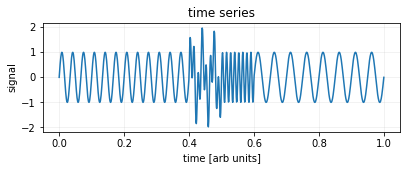

In [3]:
# choose time time points
t = np.linspace(0,1, 1000)
# make a signal with different frequencies at different times
f = np.sin(2*np.pi*30*t)*(t<0.5) + np.sin(2*np.pi*80*t)*np.logical_and(t>=0.4, t<=0.6) + np.sin(2*np.pi*20*t)*(t>0.6)

# f = signal

# let's look at our creation
plt.figure(figsize=(6.4, 2))
plt.plot(t,f)
plt.ylabel("signal")
plt.xlabel("time [arb units]")
plt.title("time series")
plt.grid(alpha=0.2)

Text(0.5, 1.0, 'Fourier Spectrum')

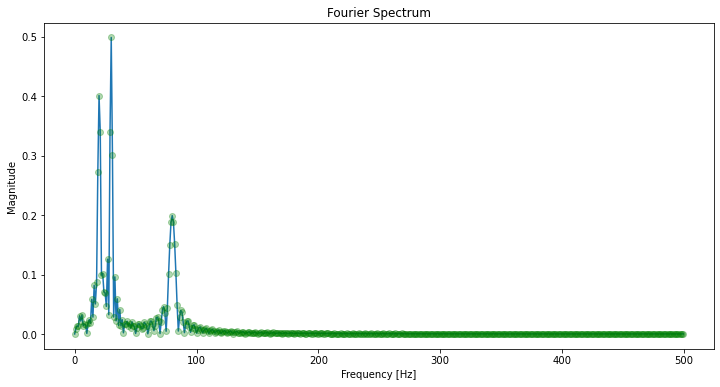

In [4]:
# improved Fourier spectrum
yf = fft(f)
# use information we know about the time values to find the frequency values
timestep = t[1] - t[0]
xf = np.linspace(0.0, 1.0/(2.0*timestep), len(t)//2) # // means floor division
plt.figure(figsize=(12, 6))
# convert to a real spectrum
plt.plot(xf, 2.0/len(t) * np.abs(yf[0:len(t)//2]))
plt.plot(xf, 2.0/len(t) * np.abs(yf[0:len(t)//2]), 'go', alpha=0.3)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum')

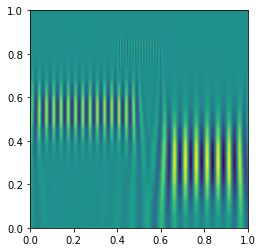

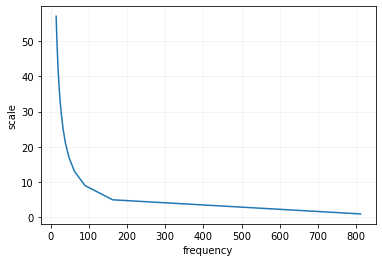

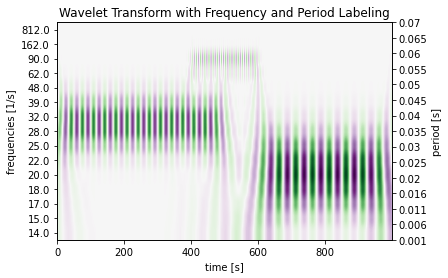

In [5]:
wavelet_name = 'morl'
scales = np.arange(1,60,4)
dt = t[1] - t[0]

[coefficients, frequencies] = pywt.cwt(f, scales, wavelet_name, dt)

plt.figure()
plt.imshow(coefficients, extent=[0,1, 0, 1], aspect=1)

###########################################################################

plt.figure()
plt.plot(frequencies, scales)
plt.grid(alpha=0.17)
plt.xlabel("frequency")
plt.ylabel("scale")

###########################################################################

from math import floor

# prepare for using twin axes
fig, ax1 = plt.subplots()

# main plot
ax1.imshow(coefficients, cmap='PRGn',  aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

# labels for left axis
ax1.set_ylabel('frequencies [1/s]')
ax1.set_yticks(np.arange(coefficients.shape[0]), labels=np.round(frequencies))

ax1.set_xlabel('time [s]')
ax1.set_title('Wavelet Transform with Frequency and Period Labeling')

# add right axis with period
ax2 = ax1.twinx()

# labels for right axis
ax2.set_ylabel('period [s]')

# floor is used to get rid of excess decimal places
strs = [str(floor(p*1e3)/1e3) for p in 1/frequencies]
ax2.set_yticks(np.arange(coefficients.shape[0]), labels=strs);

In [6]:
central_freq = 30
f_k = central_freq
freq_range = (20, 80)
delta_f = 1.0 / (freq_range[1] - freq_range[0])
alpha = 0.1
f_b, f_c = wavelet_params(f_k, delta_f, alpha)

wavelet_name = 'cmorl{:.2f}-{:.2f}'.format(f_b, f_c)
scales = np.arange(1,60,4)
dt = t[1] - t[0]

[coefficients, frequencies] = pywt.cwt(f, scales, wavelet_name, dt)

plt.figure()

########

# print("Ratio of sizes: checking if |real/imag| > tolerance")
# for ii in range(10):
#     tol = 10**(-(5-ii))
#     coef = coefficients[np.abs(np.real(coefficients) / np.imag(coefficients)) > tol].shape
#     print('Number of Coefficients exceeding tolerance of', tol, 'is', coef)

# print("Difference between np.abs() and np.real() for coefficients in cmorl wavelet")
# abscoef = np.abs(coefficients)
# realcoef = np.real(coefficients)
# avgabscoef = np.mean(abscoef)
# avgrealcoef = np.mean(realcoef)
# print(avgabscoef)
# print(avgrealcoef)

# Ratio of sizes: checking if |real/imag| > tolerance
# Number of Coefficients exceeding tolerance of 1e-05 is (15000,)
# Number of Coefficients exceeding tolerance of 0.0001 is (15000,)
# Number of Coefficients exceeding tolerance of 0.001 is (14996,)
# Number of Coefficients exceeding tolerance of 0.01 is (14939,)
# Number of Coefficients exceeding tolerance of 0.1 is (14425,)
# Number of Coefficients exceeding tolerance of 1 is (10134,)
# Number of Coefficients exceeding tolerance of 10 is (1083,)
# Number of Coefficients exceeding tolerance of 100 is (91,)
# Number of Coefficients exceeding tolerance of 1000 is (8,)
# Number of Coefficients exceeding tolerance of 10000 is (1,)
# Difference between np.abs() and np.real() for coefficients in cmorl wavelet
# 0.0006898331689172899
# -3.785573206971678e-06

### TODO: Which method is better for describing the coefficients for the complex Morlet WAvelet???
    
# plt.imshow(coefficients, extent=[0, 1, 0, 1], aspect=1)

###########################################################################

plt.figure()
plt.plot(frequencies, scales)
plt.grid(alpha=0.17)
plt.xlabel("frequency")
plt.ylabel("scale")

###########################################################################

from math import floor

# prepare for using twin axes
fig, ax1 = plt.subplots()

# main plot
ax1.imshow(coefficients, cmap='PRGn',  aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

# labels for left axis
ax1.set_ylabel('frequencies [1/s]')
ax1.set_yticks(np.arange(coefficients.shape[0]), labels=np.round(frequencies))

ax1.set_xlabel('time [s]')
ax1.set_title('Wavelet Transform with Frequency and Period Labeling')

# add right axis with period
ax2 = ax1.twinx()

# labels for right axis
ax2.set_ylabel('period [s]')

# floor is used to get rid of excess decimal places
strs = [str(floor(p*1e3)/1e3) for p in 1/frequencies]
ax2.set_yticks(np.arange(coefficients.shape[0]), labels=strs);

NameError: name 'wavelet_params' is not defined

In [ ]:
def wavelet_params(f_k, delta_f_prime):
    """
    Compute the optimal Morlet wavelet parameters given the target frequency, 
    frequency resolution, and alpha for delta_f_prime.
    
    f_k - target frequency (Main Frequency we want to recover)
    delta_f - difference in sampling frequency
    alpha - proportion of delta_f used to find resolution of wavelet transformation
    """
    f_b = (np.sqrt(2 * np.log(2)) * f_k) / (np.pi * delta_f_prime)
    f_c = np.sqrt(2 * f_b)
    
    return f_b, f_c

# choose time time points
t = np.linspace(0,1, 1000)
dt = t[1] - t[0]

# make a signal with different frequencies at different times
f = np.sin(2*np.pi*30*t)*(t<0.5) + np.sin(2*np.pi*80*t)*np.logical_and(t>=0.4, t<=0.6) + np.sin(2*np.pi*20*t)*(t>0.6)

central_freq = 20
f_k = central_freq

freq_range = np.array([20, 80])
f_n = np.argmin(np.abs(freq_range-f_k))  # Closest Frequency to f_k
delta_f = np.abs(f_k - f_n)  # Difference between target frequency and nearest frequency to target
delta_f_prime = .9 * delta_f  # Want to maximize delta_f_prime where 0 < delta_f_prime < delta_f

f_b = (np.sqrt(2 * np.log(2)) * f_k) / (np.pi * delta_f_prime)  # Optimal frequency bandwidth
f_c = np.sqrt(2 * f_b)  # Optimal central frequency

wavelet_name = 'cmorl{:.2f}-{:.2f}'.format(f_b, f_c)

# Compute scales based on the wavelet frequencies
scales = np.arange(1, 120, 4)

# # Calculate the frequencies corresponding to the scales for the Morlet wavelet
# frequencies = pywt.scale2frequency(wavelet_name, scales) / dt

# [coefficients, frequencies] = pywt.cwt(f, scales, wavelet_name, dt)
[coefficients, frequencies] = pywt.cwt(f, scales, wavelet_name, dt)
coefficients = np.abs(coefficients)
plt.figure()
plt.imshow(coefficients, extent=[0,1, 0, 1], aspect=1)

plt.figure()
plt.plot(frequencies, scales)
plt.grid(alpha=0.17)
plt.xlabel("frequency")
plt.ylabel("scale")

# prepare for using twin axes
fig, ax1 = plt.subplots()

# main plot
ax1.imshow(coefficients, cmap='PRGn',  aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

# labels for left axis
ax1.set_ylabel('frequencies [1/s]')
ax1.set_yticks(np.arange(coefficients.shape[0]), labels=np.round(frequencies))

ax1.set_xlabel('time [s]')
ax1.set_title('Wavelet Transform with Frequency and Period Labeling')

# add right axis with period
ax2 = ax1.twinx()

# labels for right axis
ax2.set_ylabel('period [s]')

# floor is used to get rid of excess decimal places
strs = [str(floor(p*1e3)/1e3) for p in 1/frequencies]
ax2.set_yticks(np.arange(coefficients.shape[0]), labels=strs);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pywt

def wavelet_params(f_k, delta_f_prime):
    """
    Compute the optimal Morlet wavelet parameters given the target frequency, 
    frequency resolution, and alpha for delta_f_prime.
    
    f_k - target frequency (Main Frequency we want to recover)
    delta_f - difference in sampling frequency
    alpha - proportion of delta_f used to find resolution of wavelet transformation
    """
    f_b = (np.sqrt(2 * np.log(2)) * f_k) / (np.pi * delta_f_prime)
    f_c = np.sqrt(2 * f_b)
    
    return f_b, f_c

# choose time time points
t = np.linspace(0, 5, 2000)
dt = t[1] - t[0]

# make a signal with different frequencies at different times
# f = np.sin(2*np.pi*30*t)*(t<0.5) + np.sin(2*np.pi*80*t)*np.logical_and(t>=0.4, t<=0.6) + np.sin(2*np.pi*20*t)*(t>0.6)
power = 2
freq = 1
f = np.sin(2*np.pi*freq*t**power)

# Defining Optimal Parameters for Complex Morlet Transform
central_freq = freq
f_k = central_freq
freq_range = np.array([freq, freq**power])
f_n = np.argmin(np.abs(freq_range-f_k))  # Closest Frequency to f_k
# TODO: HARDCODED FOR EFFECT # f_n = 4
delta_f = np.abs(f_k - f_n)  # Difference between target frequency and nearest frequency to target
delta_f_prime = .9 * delta_f  # Want to maximize delta_f_prime where 0 < delta_f_prime < delta_f
f_b = (np.sqrt(2 * np.log(2)) * f_k) / (np.pi * delta_f_prime)  # Optimal frequency bandwidth
f_c = np.sqrt(2 * f_b)  # Optimal central frequency
wavelet_name = 'cmorl{:.2f}-{:.2f}'.format(f_b, f_c)

# TODO: "How many scales do I want?"
scales = np.arange(1, 256, 5)

[coefficients, frequencies] = pywt.cwt(f, scales, wavelet_name, dt)
coefficients = np.abs(coefficients)

# prepare for using twin axes
fig, [ax1, ax2] = plt.subplots(1,2)
plt.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(10)

#############
# PLOT WVLT #
#############

# main plot
ax1.imshow(coefficients, cmap='PRGn',  aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

# labels for left axis
ax1.set_ylabel('frequencies [1/s]')
ax1.set_yticks(np.arange(coefficients.shape[0]), labels=np.round(frequencies,2))

ax1.set_xlabel('time [s]')
ax1.set_title('Wavelet Transform with Frequency and Period Labeling')

# add right axis with period
rax = ax1.twinx()

# labels for right axis
rax.set_ylabel('period [s]')

# floor is used to get rid of excess decimal places
strs = [str(math.floor(p*1e2)/1e2) for p in 1/frequencies]
rax.set_yticks(np.arange(coefficients.shape[0]), labels=strs);

##############
# PLOT Graph #
##############

ax2.plot(t,f)



# Recreation of Power Consumption Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
import pywt

# import warnings
# # Settings the warnings to be ignored 
# warnings.filterwarnings('ignore') 

### Synthetic Data 

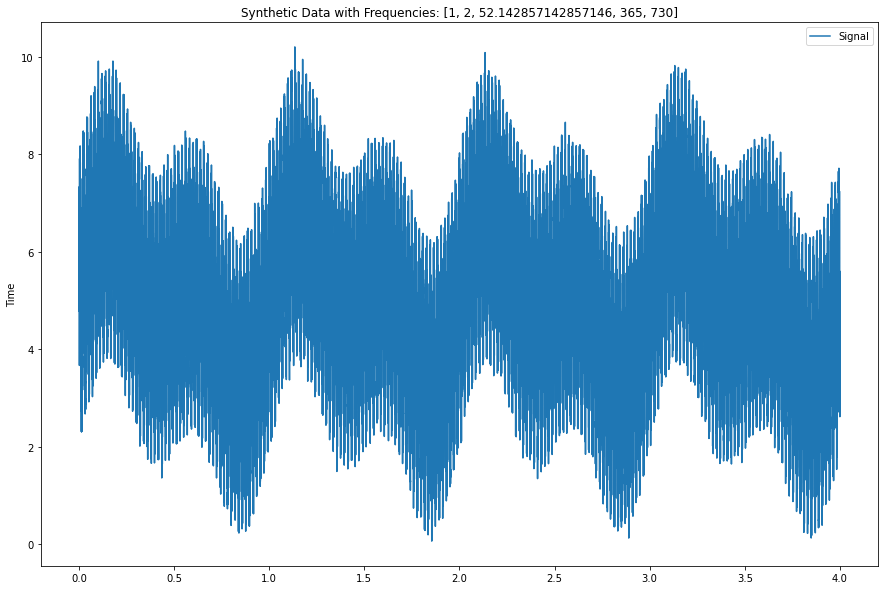

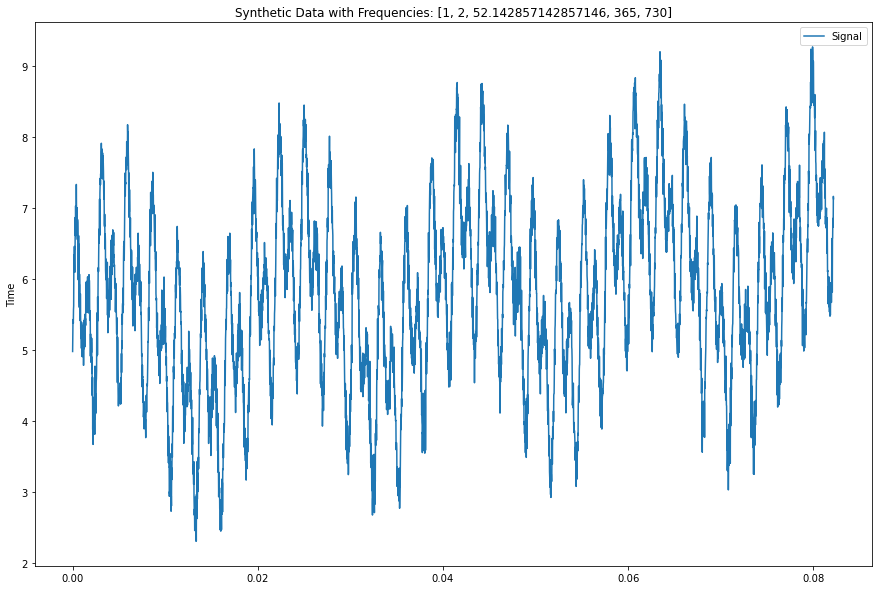

In [ ]:
num10MinPerHour = 6
numHourPerDay = 24
numDayPerYear = 365
numDayperWeek = 7
numHalfYearsPerYear = 2
numYearPerTotal = 4

numWeekPerYear = numDayPerYear/numDayperWeek  # ~52
# numDayPerYear = 365 Already Defined
numHalfDayPerYear = 2*numDayPerYear
numHourPerYear = numHourPerDay * numDayPerYear
num10MinPerYear = num10MinPerHour * numHourPerYear

num10MinPerTotal = num10MinPerYear * numYearPerTotal
tStart = 0
time = np.linspace(tStart, numYearPerTotal, num10MinPerTotal)

# freqs = [1, 2, 52, 365]  # Domain in Years -> Frequency in Years
freqs = [1, numHalfYearsPerYear, numWeekPerYear, numDayPerYear, numHalfDayPerYear]  # Domain in Years -> Frequency in Years
amplitude = 1
vShift = 1
phaseShift = 0

sinFunc = lambda t, amplitude, freq, vShift, phaseShift: amplitude*np.sin(2*np.pi*freq*(t - phaseShift)) + vShift

signalYear = sinFunc(time, amplitude, freqs[0], vShift, phaseShift)
signalHalfYear = sinFunc(time, amplitude, freqs[1], vShift, phaseShift)
signalWeek = sinFunc(time, amplitude, freqs[2], vShift, phaseShift)
signalDay = sinFunc(time, amplitude, freqs[3], vShift, phaseShift)
signalHalfDay = sinFunc(time, amplitude, freqs[4], vShift, phaseShift)

noiseAmplitude = .2
noise = noiseAmplitude*np.random.randn(num10MinPerTotal)
signal = signalHalfDay + signalDay + signalWeek + signalHalfYear + signalYear + noise

# plt.plot(time, signalYear)
# plt.plot(time, signalHalfYear)
# plt.plot(time, signalWeek)
# plt.plot(time, signalDay)
# plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(time, signal, label='Signal')
ax.set_title(f'Synthetic Data with Frequencies: {freqs}')
ax.set_ylabel('Power')
ax.set_ylabel('Time')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(time[:int(6*24*30)], signal[:int(6*24*30)], label='Signal')
ax.set_title(f'Synthetic Data with Frequencies: {freqs}')
ax.set_ylabel('Power')
ax.set_ylabel('Time')
ax.legend()
plt.show()

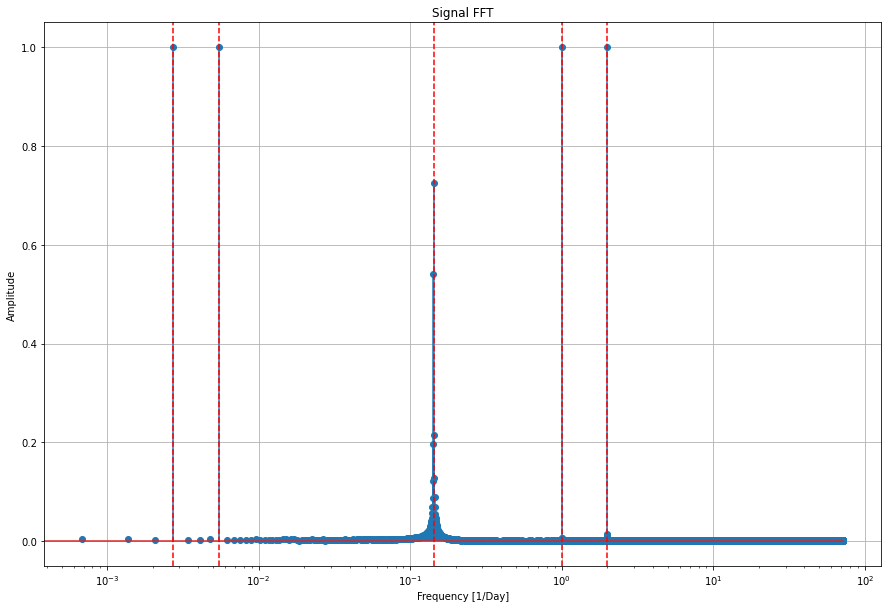

In [ ]:
centeredSignal = signal - np.mean(signal)
signalFFT = np.fft.fft(centeredSignal)
signalFFT = signalFFT / (num10MinPerTotal/2)
# signalFFT = np.fft.fftshift(signalFFT)

frequenciesFFT = np.fft.fftfreq(num10MinPerTotal, d=1/(num10MinPerHour*numHourPerDay))
# frequenciesFFT = np.fft.fftshift(frequenciesFFT)

freqFFTPositive = frequenciesFFT[:num10MinPerTotal // 2]
signalFFTPositive = signalFFT[:num10MinPerTotal // 2]

plt.figure(figsize=(15, 10))
plt.stem(freqFFTPositive, np.abs(signalFFTPositive))
plt.xscale('log')
for freq in freqs:  # Frequency Per Years -> Fequency Per Day
    plt.axvline(freq/numDayPerYear, color='r', linestyle='--')
    # plt.axvline(2*freq/numDayPerYear, color='r', linestyle='--')  # Can Be Used To Check For Numerical Artifacts
plt.ylabel('Amplitude')
plt.xlabel('Frequency [1/Day]')
plt.title('Signal FFT')
plt.grid(True)
plt.show()

## Weeks Lower Because We Have Used 52.1428... Weeks Per Year, Not 52.

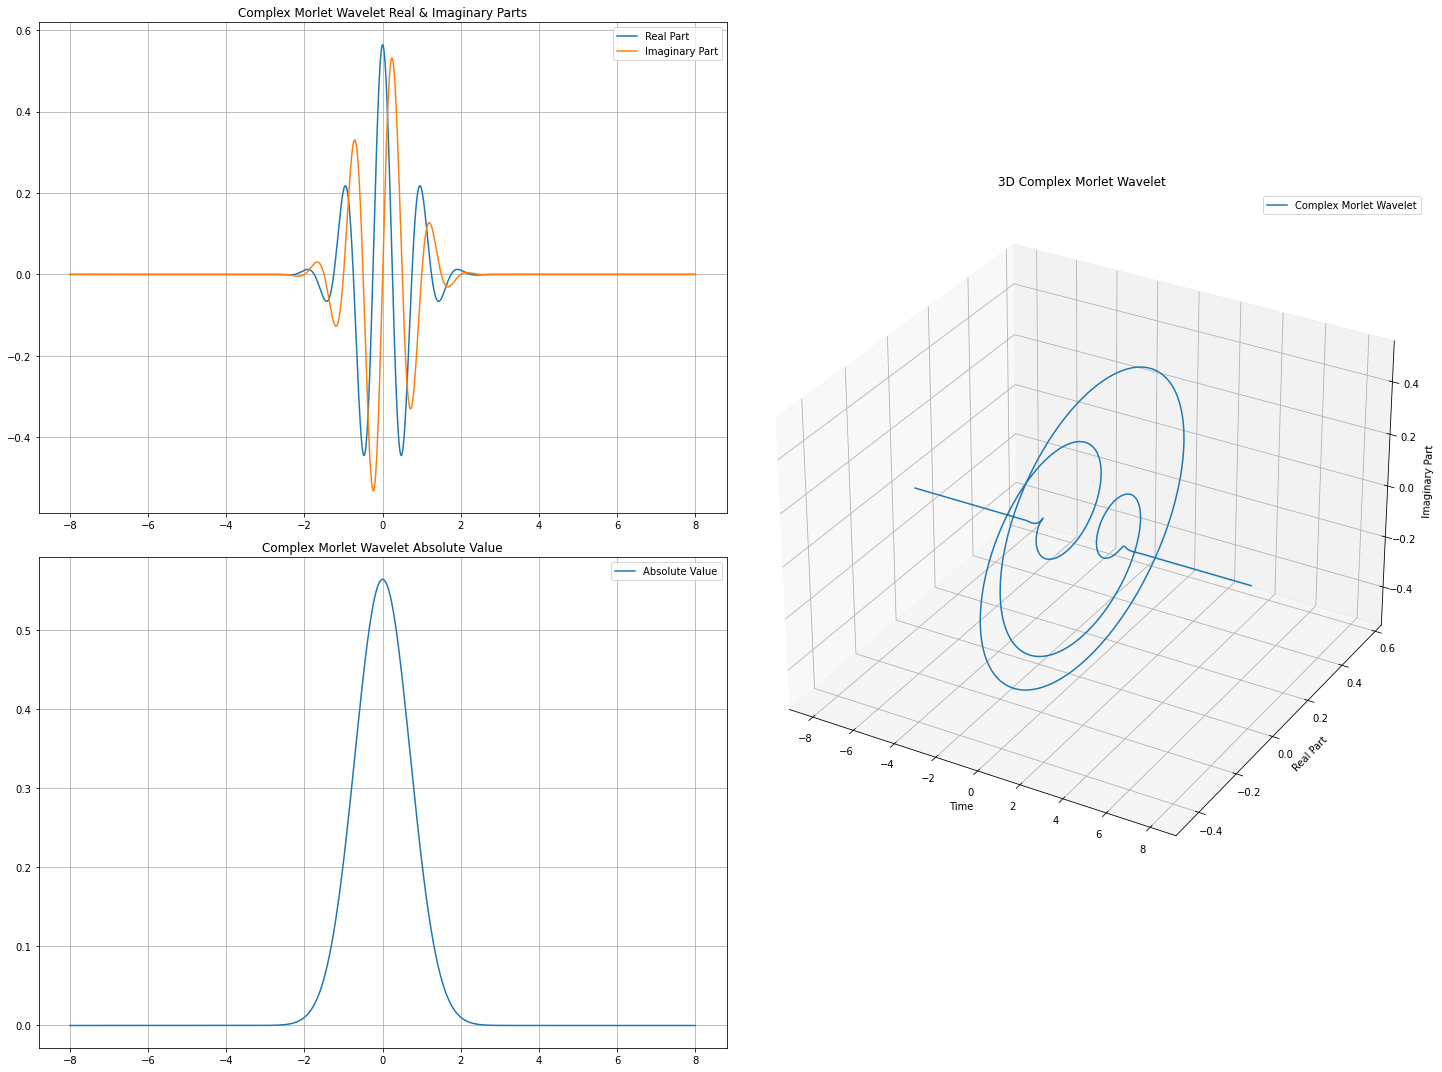

0

In [ ]:
# Create Complex Morlet Wavelet Function & Visualization
def cmorwvlt(centralFreq, bandwidthFreq, domain):
    normalization = 1/np.sqrt(np.pi*bandwidthFreq)
    psiComplex = np.exp(2*np.pi*1j*centralFreq*domain)
    psiReal = np.exp(-domain**2/bandwidthFreq)
    return normalization*psiComplex*psiReal

domainExtension = 2
timeExtended = np.linspace(-domainExtension*numYearPerTotal, domainExtension*numYearPerTotal, 2*domainExtension*num10MinPerTotal)
wavelet = cmorwvlt(1, 1, timeExtended - np.mean(timeExtended))
waveletReal = np.real(wavelet)
waveletImaginary = np.imag(wavelet)
waveletAbs = np.abs(wavelet)
waveletAbsSquare = waveletReal**2 + waveletImaginary**2

def visualizeWavelet(domain, wavelet):
    lenDomain = len(domain)
    waveletReal = np.real(wavelet)
    waveletImaginary = np.imag(wavelet)
    waveletAbs = np.abs(wavelet)
    waveletAbsSquare = waveletReal**2 + waveletImaginary**2

    fig = plt.figure(figsize=(20, 15))

    ax1 = fig.add_subplot(221)
    ax1.plot(domain, waveletReal[:lenDomain], label='Real Part')
    ax1.plot(domain, waveletImaginary[:lenDomain], label='Imaginary Part')
    ax1.set_title('Complex Morlet Wavelet Real & Imaginary Parts')
    ax1.legend()
    ax1.grid(True)

    ax2 = fig.add_subplot(223)
    ax2.plot(domain, waveletAbs[:lenDomain], label='Absolute Value')
    ax2.set_title('Complex Morlet Wavelet Absolute Value')
    ax2.legend()
    ax2.grid(True)

    ax3 = fig.add_subplot(122, projection='3d')
    ax3.plot(domain, waveletReal[:lenDomain], waveletImaginary[:lenDomain], label='Complex Morlet Wavelet')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Real Part')
    ax3.set_zlabel('Imaginary Part')

    ax3.set_title('3D Complex Morlet Wavelet')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

    return 0

visualizeWavelet(domain=timeExtended, wavelet=wavelet)

In [ ]:
# Check Mathematical Wavelet Properties

dt = numYearPerTotal/num10MinPerTotal

errorAll = np.trapz(wavelet, timeExtended)
errorAbs = np.trapz(waveletAbs, timeExtended)
errorAbsSquare = np.trapz(waveletAbsSquare, timeExtended)

print(f'Integral Of Wavelet should be (0,0): {np.round(errorAll, 4)}')
print(f'Integral Of |Wavelet| should be 1: {np.round(errorAbs, 4)}')
print(f'Integral Of |Wavelet|^2 should be 1: {np.round(errorAbsSquare, 4)}')

Integral Of Wavelet should be (0,0): (0.0001-0j)
Integral Of |Wavelet| should be 1: 1.0
Integral Of |Wavelet|^2 should be 1: 0.3989


In [ ]:
def convolution(signal, wavelet):  # Unneccessary Since Numpy has np.convolve()... I forgot
    signalFFT = np.fft.fft(signal)
    waveletFFT = np.fft.fft(wavelet)
    return np.fft.ifft(signalFFT*waveletFFT)

### Create a function that subsamples wavelet until a certain accuracy tolerance is reached

-> Possibly Useful For Speed Up When Computing Full Heat Maps

(420480,)
(210240,)
(105120,)
(52560,)
(26280,)
(13140,)
(6570,)
(3285,)
(1643,)
(822,)
(411,)
(206,)
(103,)
(52,)
(26,)

16384
(52,)
5.172318620355609e-05
5.172318620381283e-05


c:\Users\chris\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


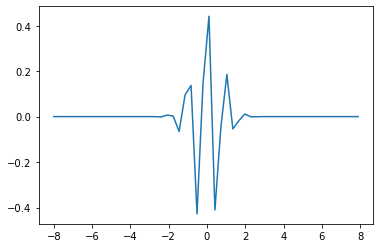

In [ ]:
def subsampleArray(array, domain, tolerance, expectedError):

    error = np.abs(np.trapz(array, domain))
    error = np.round(error, int(-np.log(tolerance)))

    subsampleRate = 1
    sampledArray = lambda subsample: array[::subsample]
    sampledDomain = lambda subsample: domain[::subsample]

    while (error - expectedError) < tolerance:

        subsampleRate *= 2

        subsampledArray = sampledArray(subsampleRate)
        subsampledDomain = sampledDomain(subsampleRate)

        error = np.abs(np.trapz(subsampledArray, subsampledDomain))
        error = np.round(error, int(-np.log(tolerance)))

        print(subsampledArray.shape)


    return int(subsampleRate / 2)

subSampleRate = subsampleArray(wavelet, timeExtended, 1e-4, 0)
print()
print(subSampleRate)
print(wavelet[::subSampleRate].shape)

plt.plot(timeExtended[::subSampleRate], wavelet[::subSampleRate])

error = np.abs(np.trapz(wavelet[::subSampleRate], timeExtended[::subSampleRate]))
print(error)

error = np.abs(np.trapz(wavelet, timeExtended))
print(error)


In [ ]:
def optimalWaveletParams(targetFrequency, nextClosestFrequency, alpha=.9):
    deltafprime = alpha*(np.abs(targetFrequency-nextClosestFrequency))
    bandwidthFrequency = np.sqrt(2*np.log(2))*targetFrequency/(np.pi*deltafprime)
    centralFrequency = np.sqrt(2 * bandwidthFrequency)
    return centralFrequency, bandwidthFrequency

centralFrequency, bandwidthFrequency = optimalWaveletParams(freqs[0], freqs[1])

cmorWavelet = cmorwvlt(centralFrequency, bandwidthFrequency, time)

waveletTransform = np.convolve(signal, cmorWavelet)

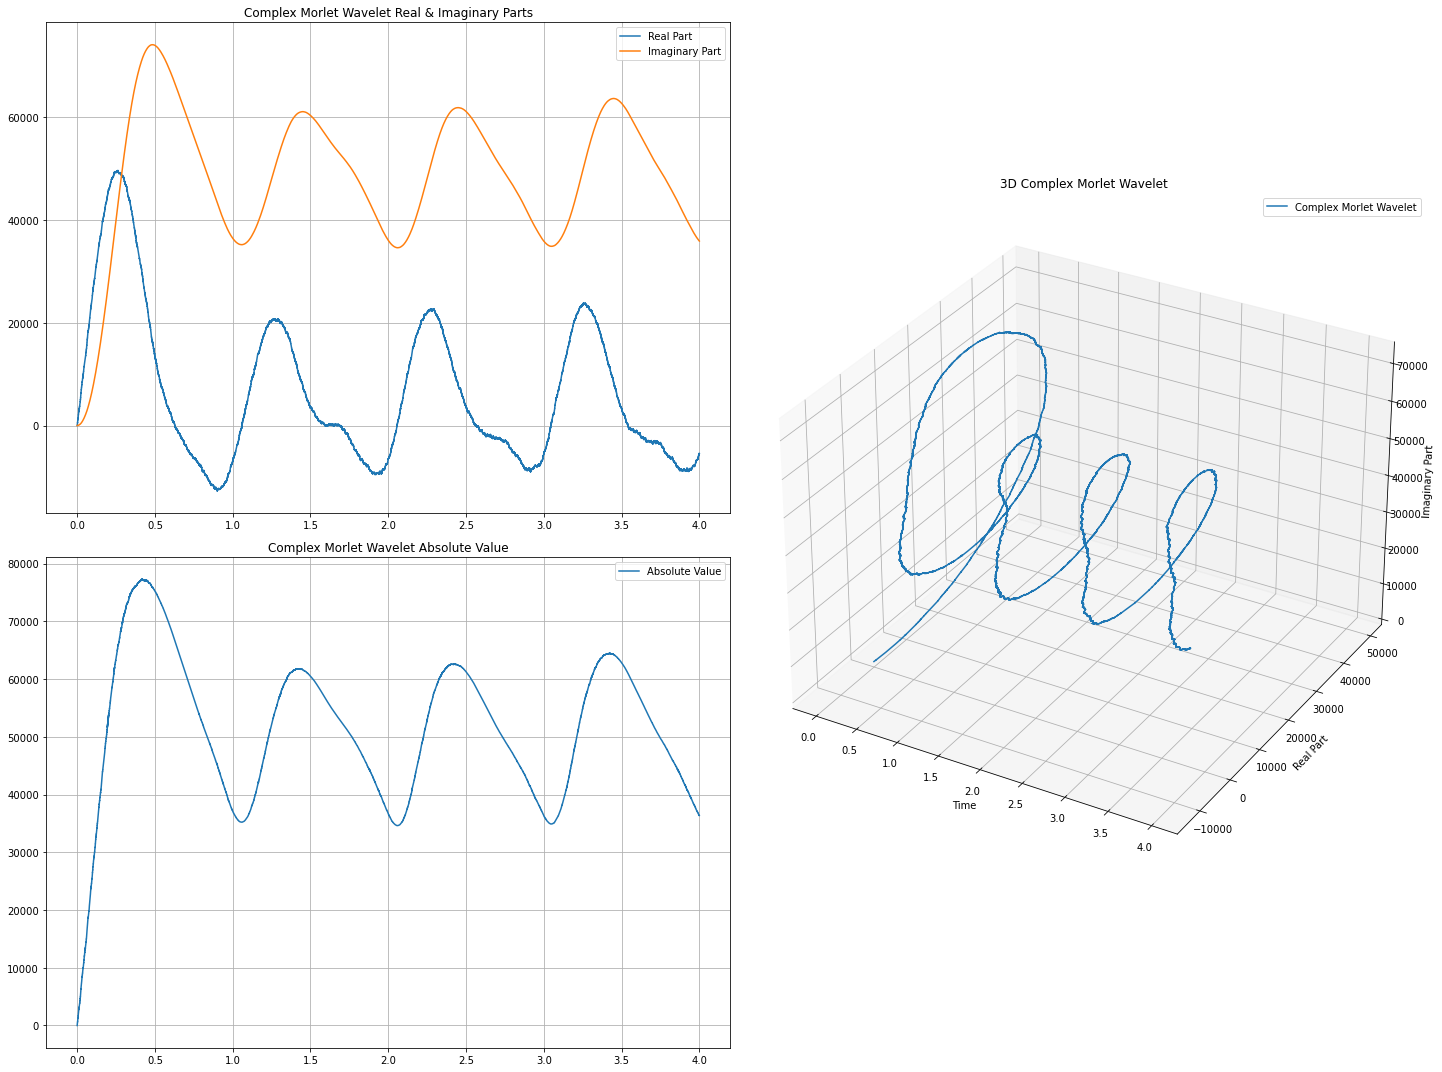

0

In [ ]:
visualizeWavelet(domain=time, wavelet=waveletTransform)

In [ ]:
dataset = pd.read_csv('PJM_Load_hourly.csv')
# Displaying the data
dataset.head(3)

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0


(32896,)


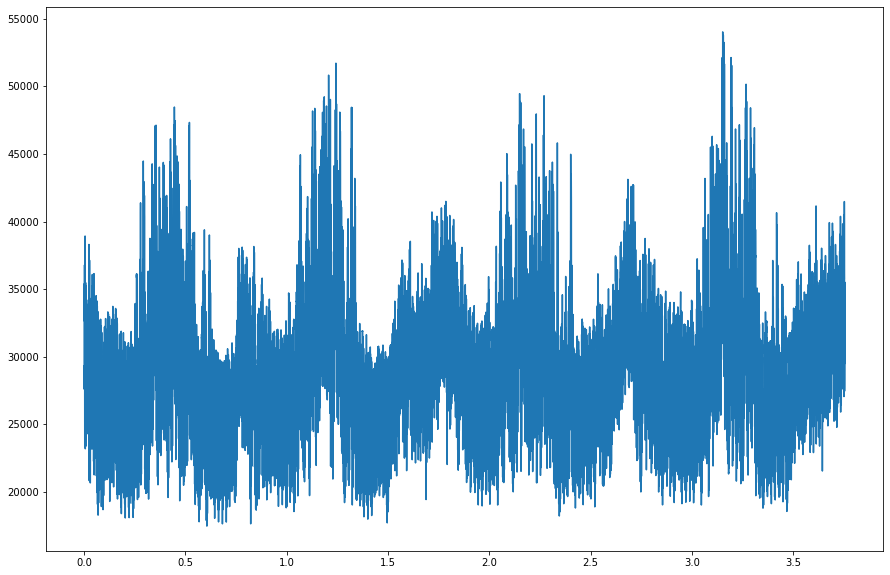

In [ ]:
signalData = np.array(dataset['PJM_Load_MW'])
print(signalData.shape)

fig = plt.figure(figsize=(15,10))
plt.plot(domainData, signalData)

### Data Collected Over Almost 4 Years at 1 Hour Intervals:

Proof: 32896/(4 * 365 * 24) ~ 0.93

Data is sampled in [1 hour] segments, but we want to calculate with respect to [1 day]. Therefore, the FFT can be calculated by:

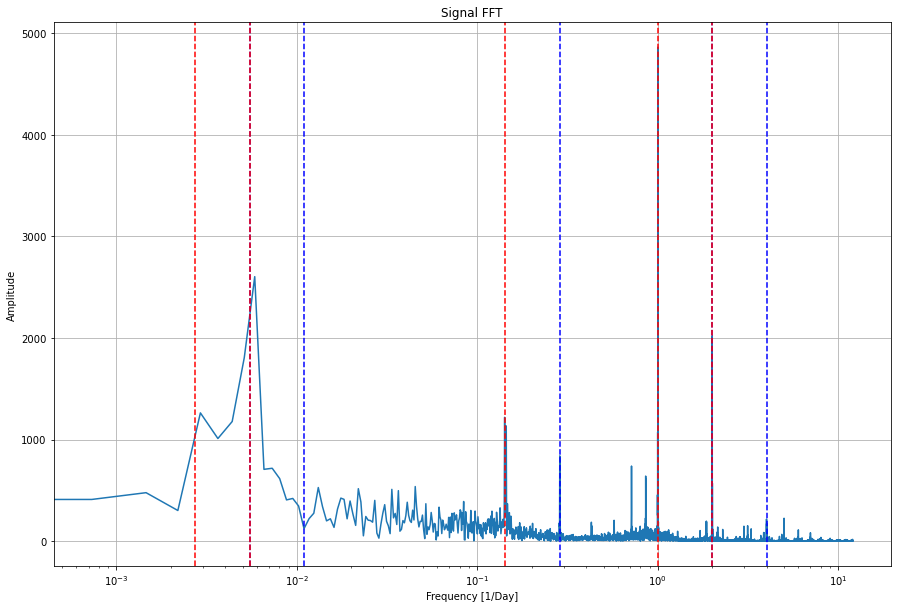

In [ ]:
dataLength = len(signalData)
numHours = dataLength
numHourPerDay = 24
numDayPerYear = 365

domainData = np.linspace(0, numHours/(numHourPerDay*numDayPerYear), numHours)

centeredSignalData = signalData - np.mean(signalData)
signalDataFFT = np.fft.fft(centeredSignalData)
signalDataFFT = signalDataFFT / (dataLength/2)
signalDataFFT = np.fft.fftshift(signalDataFFT)

frequenciesDataFFT = np.fft.fftfreq(dataLength, d=1/(numHourPerDay))
frequenciesDataFFT = np.fft.fftshift(frequenciesDataFFT)

plt.figure(figsize=(15, 10))
plt.semilogx(frequenciesDataFFT, np.abs(signalDataFFT))

## Frequencies of Power Data Should Match Frequencies Defined in Simulated Data From Previous EDA ##
for freq in freqs:  # Frequency Per Years -> Fequency Per Day
    plt.axvline(freq/numDayPerYear, color='r', linestyle='--', label='Expected Frequency')
    plt.axvline(2*freq/numDayPerYear, color='b', linestyle='--', label='Numerical Frequency?')  # Can Be Used To Check For Numerical Artifacts
plt.ylabel('Amplitude')
plt.xlabel('Frequency [1/Day]')
plt.title('Signal FFT')
plt.grid(True)
plt.show()

## (From Above FFT Plot) Small Spikes On The Same Order of The Largest Frequency Should Be Taken Into Account

### Main Frequencies ~ 1 Day, 1/2 Year, 12 Hours, 1 Year, 1 Week, ...

In Standard [1/Year] Units = 365, 2, 730, 1, 365/7

In [ ]:
frequenciesData = np.array([365, 2, 730, 1, 365/7])

def getNextClosestElement(array):
    array = array.astype(float) # To Prevent Overflow During np.fill_diagonals()

    differnceMatrix = np.abs(array - array[:, np.newaxis])  
    np.fill_diagonal(differnceMatrix, np.inf)  # So Minima Are 'Next' Closest Elements, Not Themselves
    minDiffIndxs = np.argmin(differnceMatrix, axis=1)  # Find Indices of Next Closest Elements
    return array[minDiffIndxs]

nextClosestFrequency = getNextClosestElement(frequenciesData)

print(nextClosestFrequency)

[ 52.14285714   1.         365.           2.           2.        ]


Frequency: 365.0 with Wavelet Parameters: fc = 0.98572566835957, fb = 0.48582754663146044


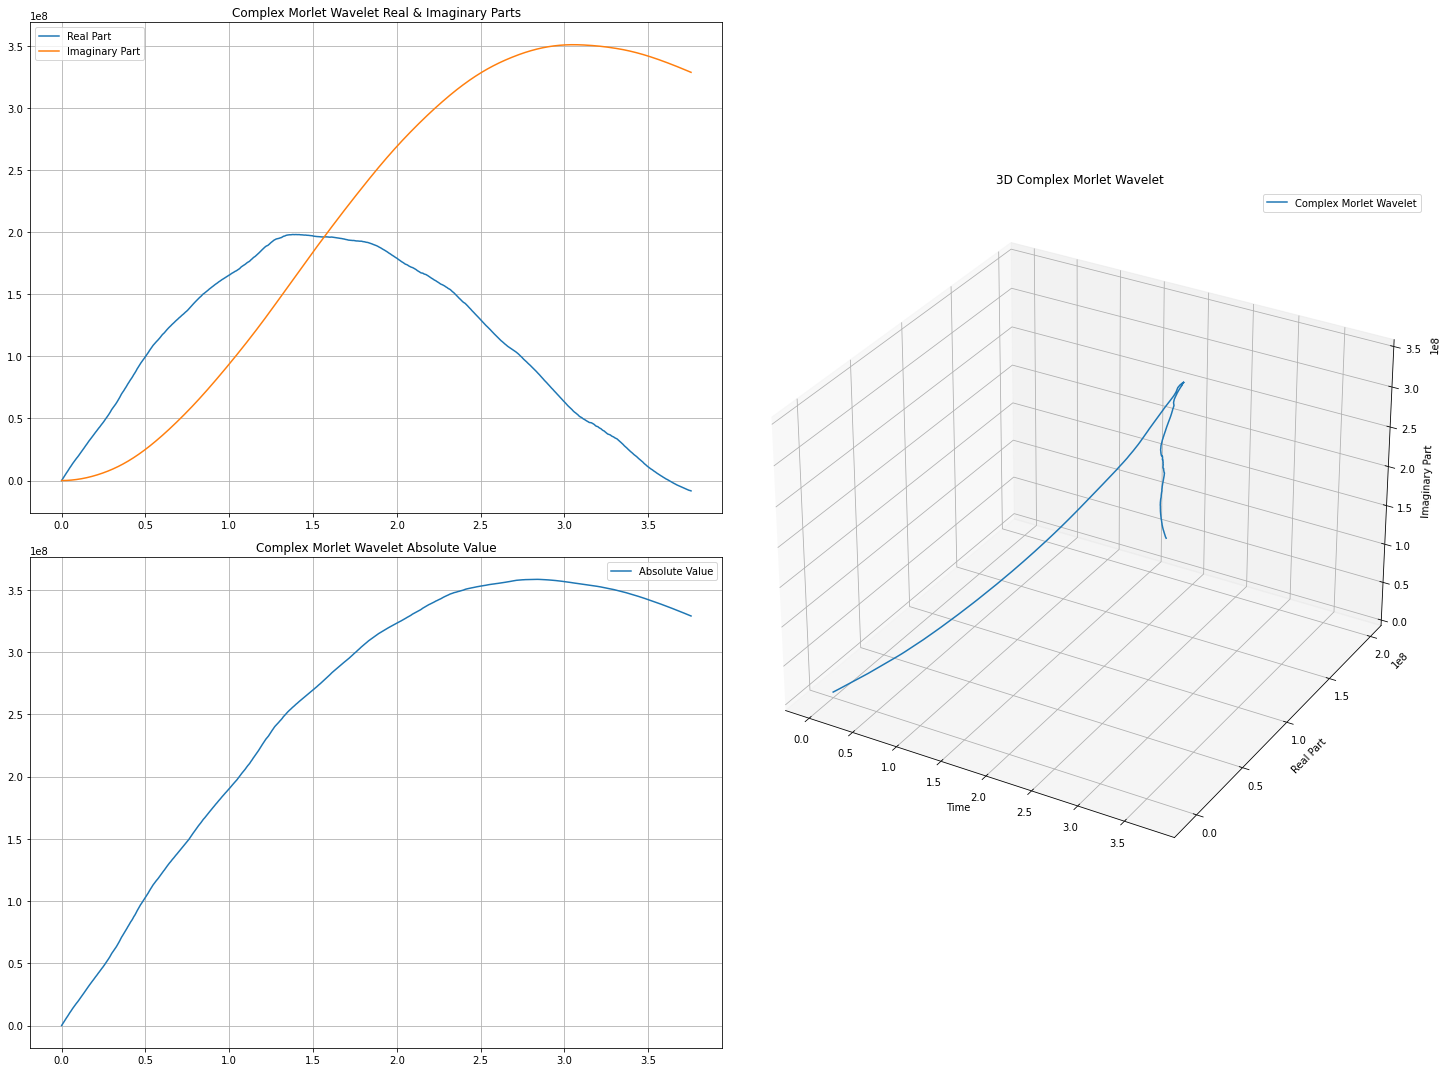

Frequency: 2.0 with Wavelet Parameters: fc = 1.290617854205333, fb = 0.8328472227967892


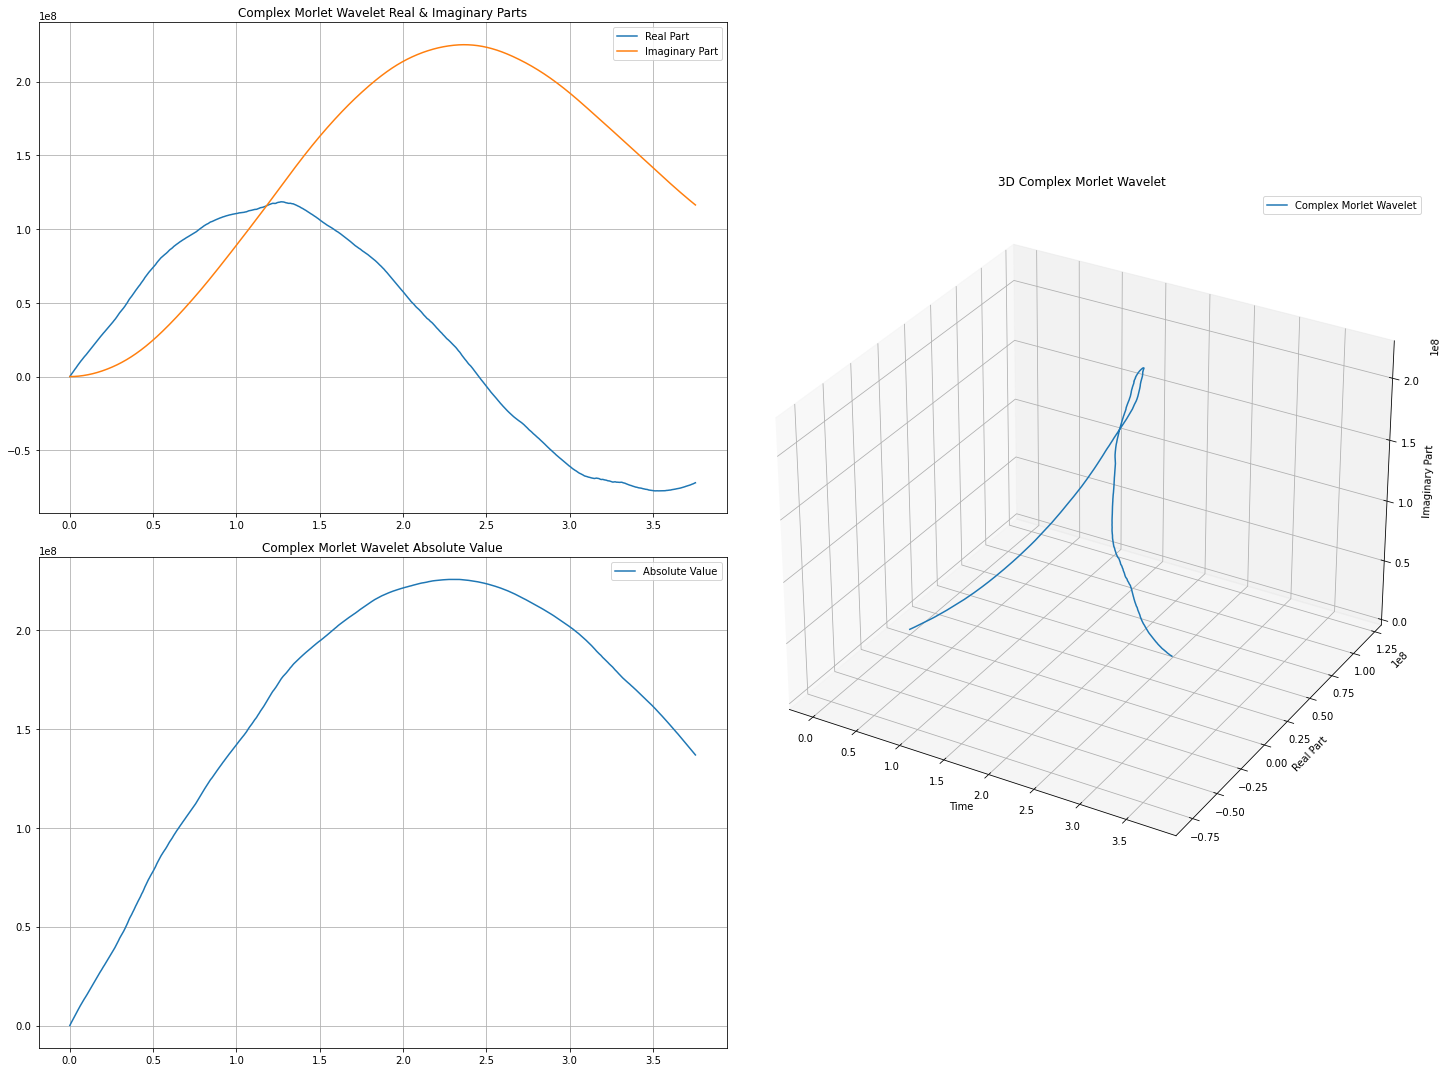

Frequency: 730.0 with Wavelet Parameters: fc = 1.290617854205333, fb = 0.8328472227967892


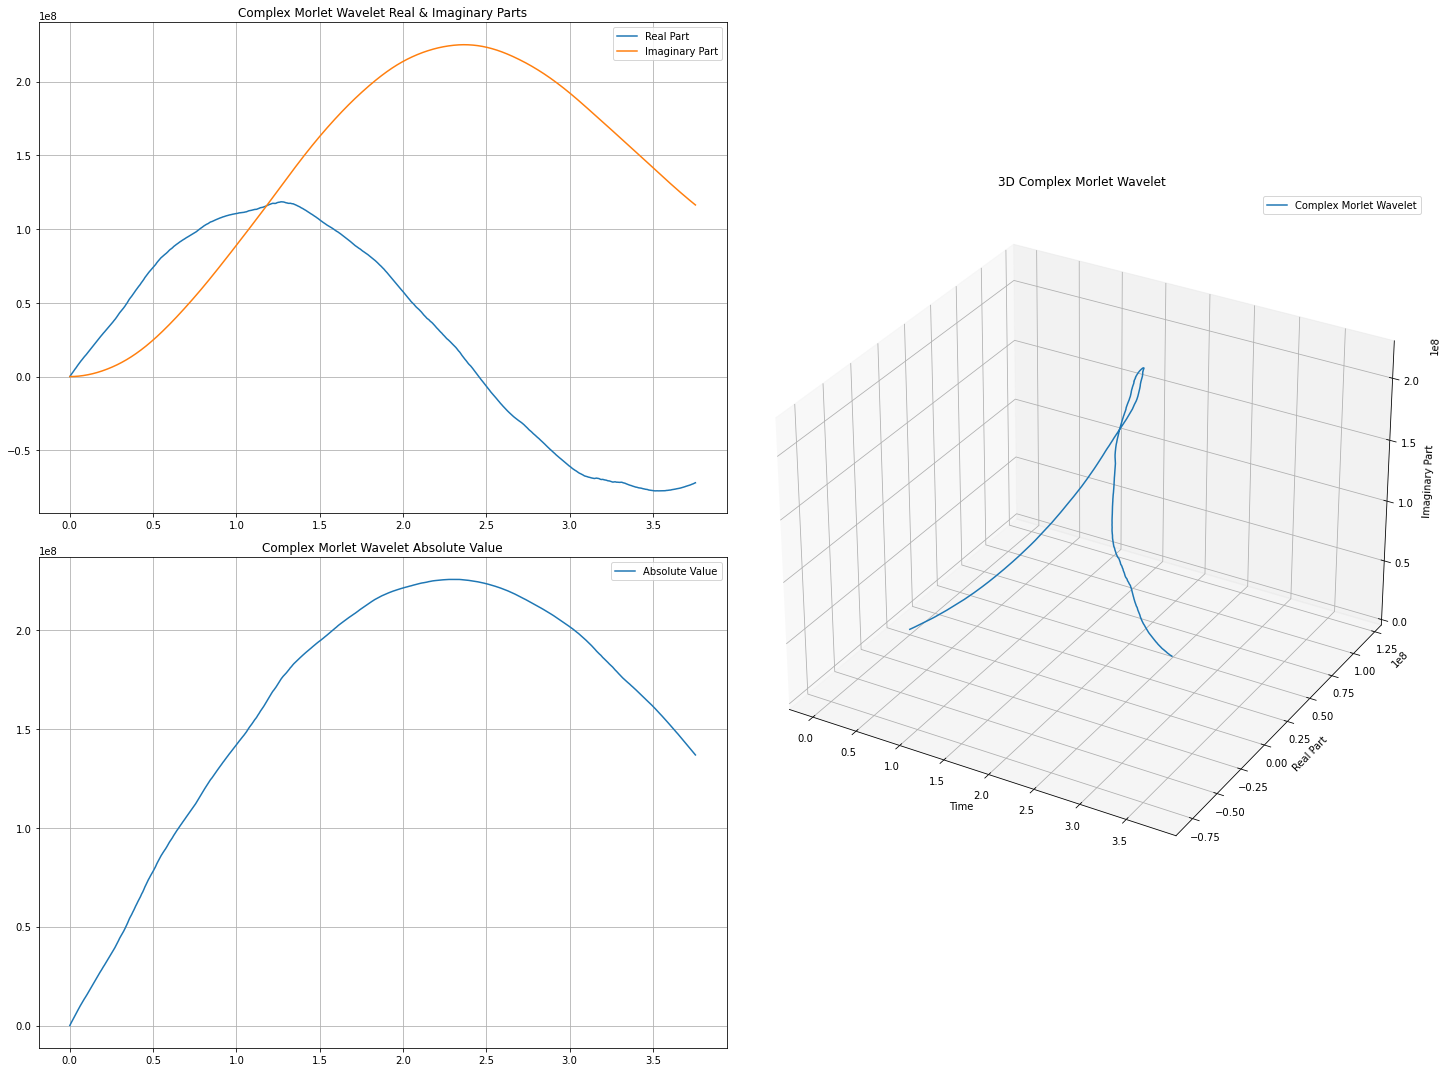

Frequency: 1.0 with Wavelet Parameters: fc = 0.912604636629022, fb = 0.4164236113983946


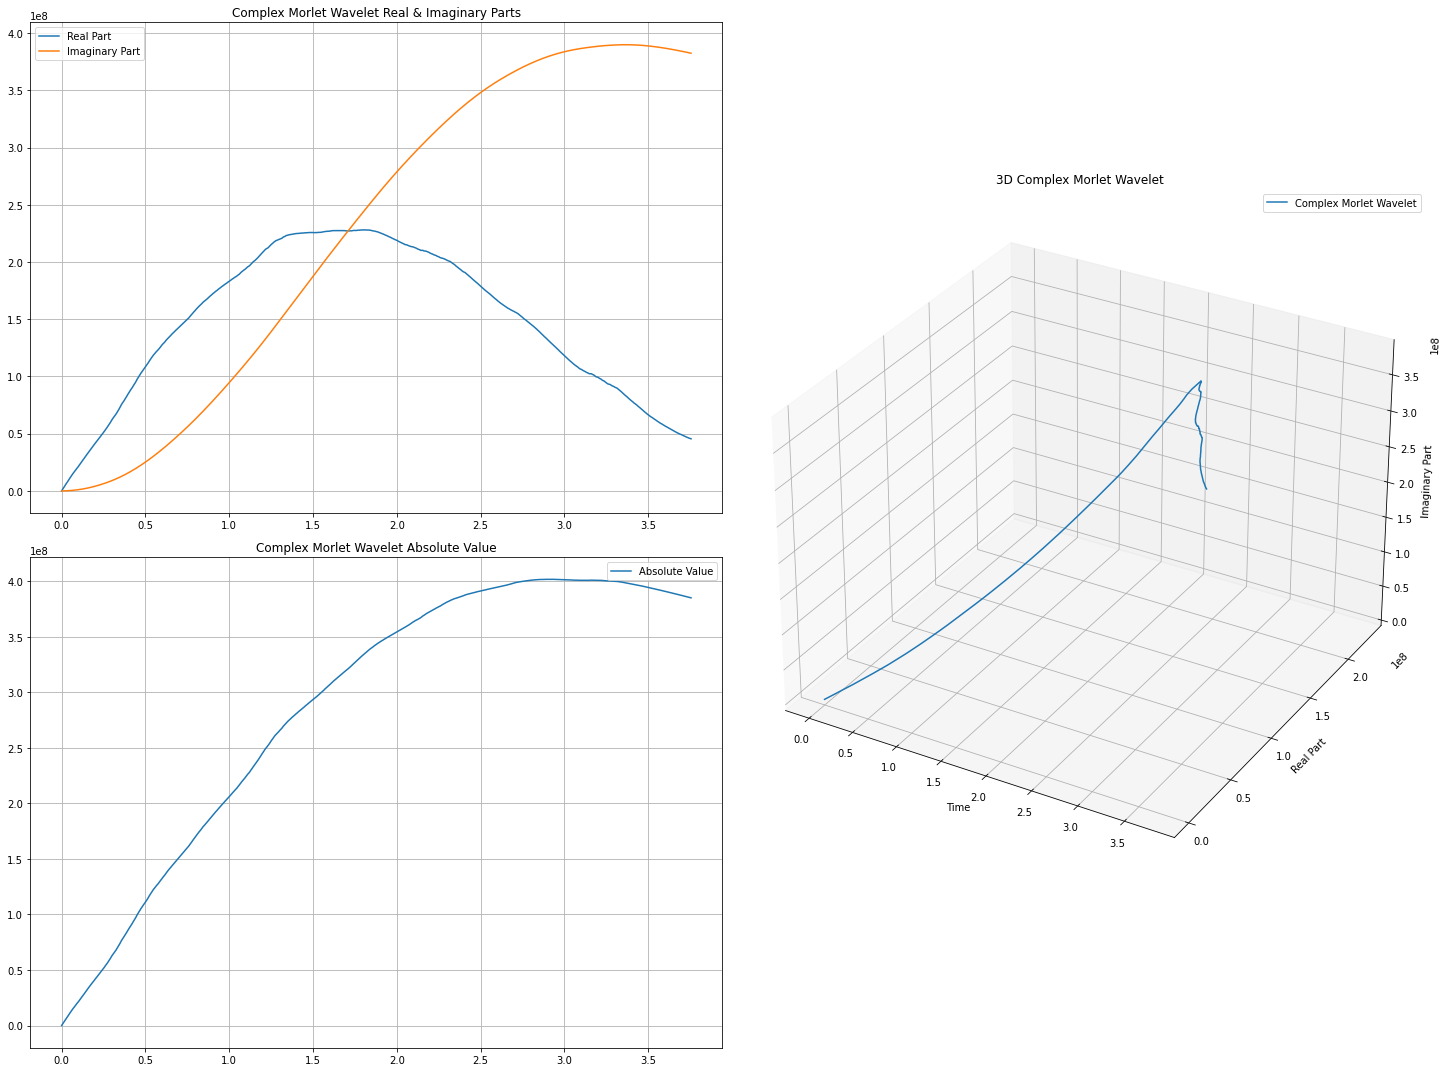

Frequency: 52.142857142857146 with Wavelet Parameters: fc = 0.9306267782222042, fb = 0.43303310017211977


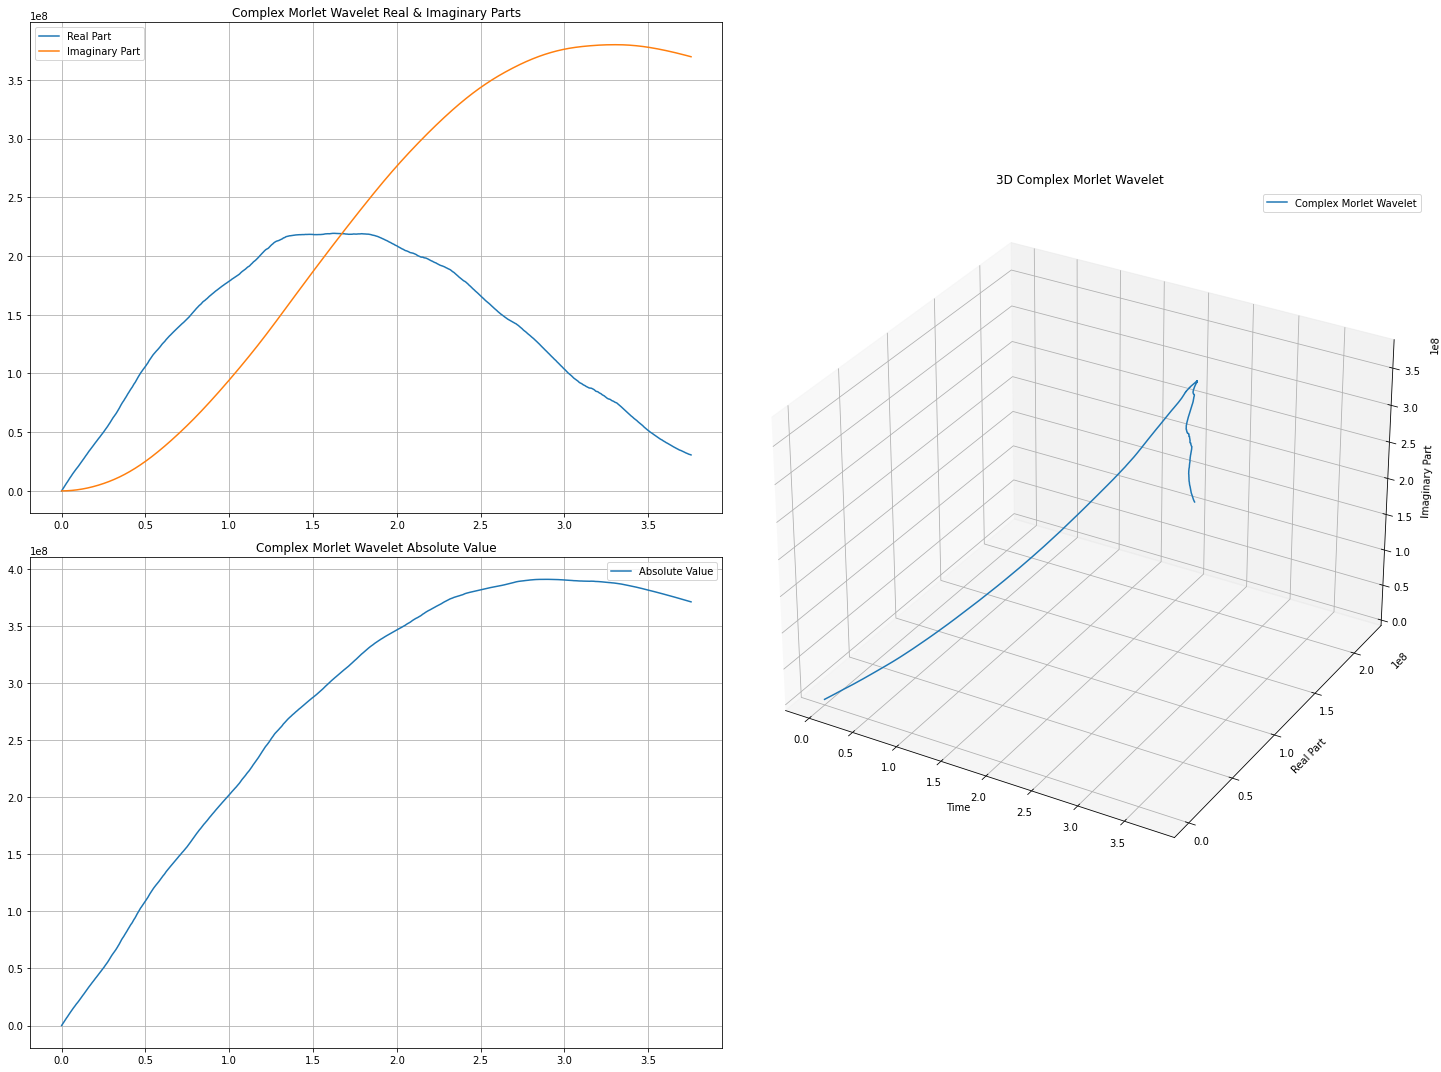

In [ ]:
for freq, nextClosestFreq in zip(frequenciesData, nextClosestFrequency):
    centralFrequency, bandwidthFrequency = optimalWaveletParams(targetFrequency=freq, nextClosestFrequency=nextClosestFreq)

    cmorWavelet = cmorwvlt(centralFrequency, bandwidthFrequency, time)

    waveletTransformData = np.convolve(signalData, cmorWavelet)

    print(f'Frequency: {freq} with Wavelet Parameters: fc = {centralFrequency}, fb = {bandwidthFrequency}')
    visualizeWavelet(domainData, waveletTransformData)

### Create Heat Map Of Wavelet Transform

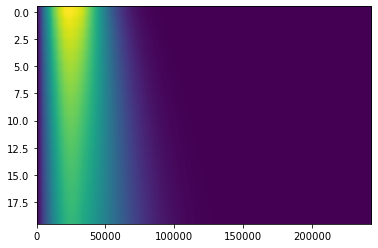

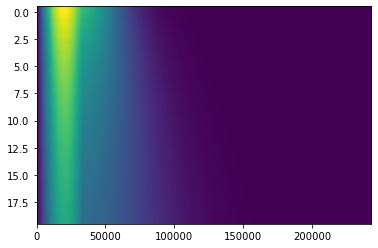

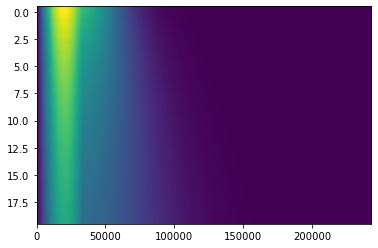

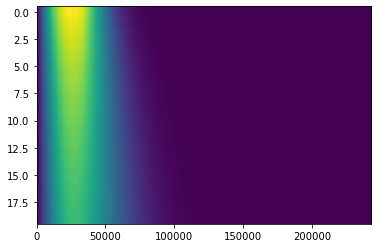

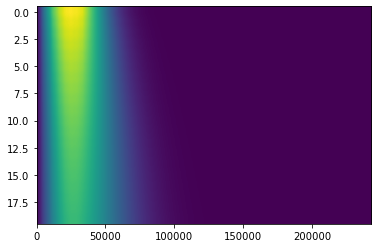

In [ ]:
def waveletTransformSpectrum(targetFrequency, nextClosestFrequency, bandwidthScaling, waveletDomain=time, signal=signalData):
        
    centralFrequency, bandwidthFrequency = optimalWaveletParams(targetFrequency=freq, nextClosestFrequency=nextClosestFreq)

    minbandwidth = (1-bandwidthScaling)*bandwidthFrequency
    maxbandwidth = (1+bandwidthScaling)*bandwidthFrequency

    rangeBandwidths = np.linspace(minbandwidth, maxbandwidth, 20)

    rangeWaveletTransforms = []

    for aBandwidth in rangeBandwidths:
        cmorWavelet = cmorwvlt(centralFrequency, aBandwidth, waveletDomain)
        waveletTransform = np.convolve(signal, cmorWavelet)
        rangeWaveletTransforms.append(waveletTransform)

    rangeWaveletTransforms = np.array(rangeWaveletTransforms)

    return rangeWaveletTransforms




for freq, nextClosestFreq in zip(frequenciesData, nextClosestFrequency):
    wvltTrnsfrmSpctrm = waveletTransformSpectrum(targetFrequency=freq, nextClosestFrequency=nextClosestFreq, bandwidthScaling = .5, waveletDomain=time, signal=signalData)

    plt.imshow(np.abs(wvltTrnsfrmSpctrm), aspect='auto')
    plt.show()


In [ ]:
wvltTrnsfrmSpctrm.shape

AttributeError: 'NoneType' object has no attribute 'shape'

# Going Back To PyWt: Use Frequencoes tp Construct Scales

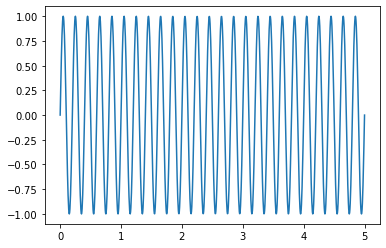

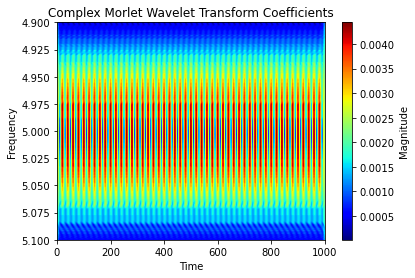

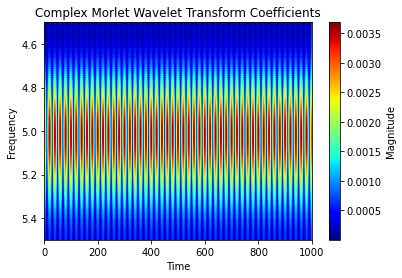

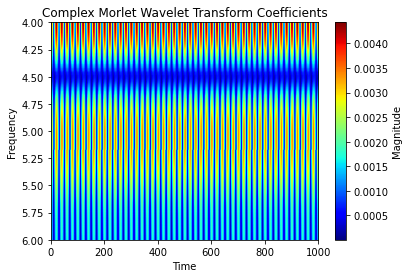

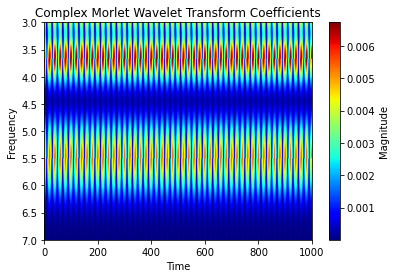

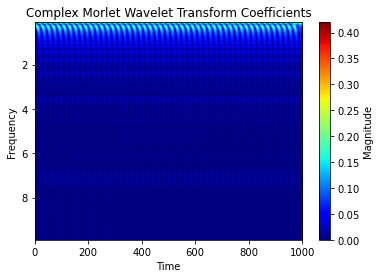

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def wavelet_params(f_k, delta_f_prime):
    """
    Compute the optimal Morlet wavelet parameters given the target frequency, 
    frequency resolution.
    
    Parameters:
    - f_k: target frequency (Main Frequency we want to recover)
    - delta_f_prime: Frequency resolution parameter.
    """
    f_b = (np.sqrt(2 * np.log(2)) * f_k) / (np.pi * delta_f_prime)
    f_c = np.sqrt(2 * f_b)
    
    return f_b, f_c

def complex_morlet_wavelet_transform(signal, target_freq, delta_f_prime, sampling_period=1.0):
    """
    Performs a Complex Morlet Wavelet Transformation on a signal and generates a heatmap,
    using custom parameters for the wavelet.
    
    Parameters:
    - signal: The input signal to be transformed.
    - target_freq: The target frequency for the wavelet.
    - delta_f_prime: Frequency resolution parameter.
    - sampling_period: The sampling period of the signal.
    """
    # Compute the wavelet parameters
    f_b, f_c = wavelet_params(target_freq, delta_f_prime)
    wavelet_name = f"cmor{f_b}-{f_c}"
    
    # Determine the appropriate scales
    frequencies = np.linspace(target_freq - delta_f_prime, target_freq + delta_f_prime, num=1000)
    scales = pywt.scale2frequency(wavelet_name, frequencies) / sampling_period
    
    # Perform the Continuous Wavelet Transform (CWT)
    coef, freqs = pywt.cwt(signal, scales, wavelet_name, sampling_period=sampling_period)
    
    # Plotting the heatmap of the coefficients
    plt.imshow(np.abs(coef), extent=[0, len(signal), max(frequencies), min(frequencies)], cmap='jet', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('Complex Morlet Wavelet Transform Coefficients')
    plt.show()

# Example: Sinusoidal signal with specific frequency and amplitude
def generate_sinusoidal_signal(freqs, amp, duration=5.0, num_samples = 1000):
    t = np.linspace(0, duration, num_samples)
    signal = np.zeros(len(t))
    for freq in freqs:
        signal += amp * np.sin(2 * np.pi * freq * t)
    return t, signal

# Generate a sinusoidal signal
frequency = [5]  # frequency of the sinusoidal signal
amplitude = 1  # amplitude of the sinusoidal signal
t, signal = generate_sinusoidal_signal(frequency, amplitude)

plt.plot(t,signal)
plt.show()

# Example parameters
target_freq = [5, 5, 5, 5, 5]  # Target frequency for wavelet parameters
delta_f_prime = [0.1, 0.5, 1, 2, 4.9]  # Frequency resolution

# Perform the complex morlet wavelet transform with custom parameters and plot the heatmap

for atarget_freq, adelta_f_prime in zip(target_freq, delta_f_prime):
        complex_morlet_wavelet_transform(signal, atarget_freq, adelta_f_prime)


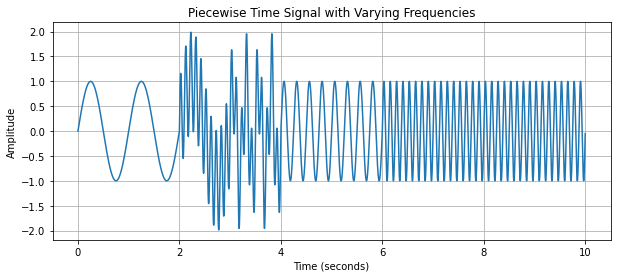

c:\Users\chris\anaconda3\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


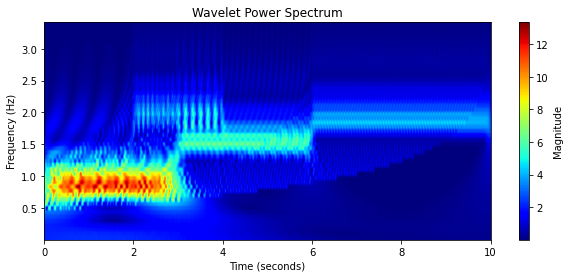

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Define the duration of the signal and the sampling rate
duration = 10
sampling_rate = 1000
freqs = [1, 4, 8, 10]
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define a lambda function for creating piecewise components of the signal
signal_piecewise = lambda start, end, freq: np.sin(2 * np.pi * freq * t) * np.logical_and(t > start, t < end)

# Generate the piecewise signal
signal = np.zeros_like(t)
signal += signal_piecewise(0, 0.3 * duration, freqs[0])
signal += signal_piecewise(0.3 * duration, 0.6 * duration, freqs[1])
signal += signal_piecewise(0.6 * duration, duration, freqs[2])
signal += signal_piecewise(0.2 * duration, 0.4 * duration, freqs[3])

# Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(t, signal)
plt.title('Piecewise Time Signal with Varying Frequencies')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Now let's perform the wavelet transform using PyWavelets
wavelet_name = 'cmor'

# Given values for fmin, fmax, and f0
fmin = 2  # Minimum frequency
fmax = 6  # Maximum frequency
f0 = 3    # Center frequency for the Morlet wavelet
num_freqs = 100
wvlt_freqs = np.logspace(fmin, fmax, num_freqs)

# Let f = scale2frequency. Then f(f(x)) = x.
# s0 = pywt.scale2frequency(f0)
# scales = pywt.scale2frequency(wvlt_freqs)



##########################################################################################################
# What is the relationship between scales and frequency in a Morlet wavelet transform?
# I'm using PyWavelets, with a complex Morlet wavelet. Its complex wavelet transform function requires 
# scales as one of its parameters, rather than frequencies. However, I don't understand the relationship
#  between the two. I'm generating my scales like this:

# base_scale = CENTER_FREQ * quality / base_freq
# far_scale = base_scale / 2**num_octaves
# scales = numpy.geomspace(base_scale, far_scale, num=num_octaves*voices_per_octave+1, endpoint=True)

# That is, if I expect my signal to be at about 20 kHz, I want to set the scales to be such that the frequencies 
# returned are between 10 kHz and 40 kHz. In this case, the num_octaves variable might be 2, base_freq would be 10000, 
# and voices_per_octave might be 50. Then scales would be an array of length 101, ranging logarithmically from the scale 
# corresponding to 10 kHz up to the scale corresponding to 40 kHz.

# However, this only works if CENTER_FREQ (the wavelet's central frequency) is a small number. If I increase it beyond 31, the frequencies returned by:

# coeffs, freqs = pywt.cwt(data, scales, wavelet, 1/quality)
# (where quality is the sampling rate of the data) are dead wrong. Is there any easier way to determine the needed scales that correspond to the frequencies I want?
##########################################################################################################
base_freq = 1
base_scale = f0 * sampling_rate / base_freq
num_octaves = 10
voices_per_octave = 5
far_scale = base_scale / 2**num_octaves
scales = np.geomspace(base_scale, far_scale, num=num_octaves*voices_per_octave+1, endpoint=True)


# # Determine the number of scales (values) on a log scale between smin and smax
# # We use a log2 scale to ensure a multiplicative step size that's proportional on a log scale
# num_scales = int(np.ceil(np.log2(smax / smin))) + 1  # +1 to ensure we include smax

# # Create the scale array using a geometric progression (which corresponds to a log scale in frequency)
# scales = np.geomspace(smin, smax, num=num_scales)

# frequencies = pywt.scale2frequency(wavelet_name, scales)
##########################################################################################################

# scales = np.arange(1, 128)  # Range of scales

# Perform the Continuous Wavelet Transform (CWT)
coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)

# Plot the wavelet power spectrum
plt.figure(figsize=(10, 4))
plt.imshow(np.abs(coefficients), extent=[0, duration, frequencies.min(), frequencies.max()], cmap='jet', aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('Wavelet Power Spectrum')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.show()

What is the relationship between scales and frequency in a Morlet wavelet transform?
I'm using PyWavelets, with a complex Morlet wavelet. Its complex wavelet transform function requires 
scales as one of its parameters, rather than frequencies. However, I don't understand the relationship
 between the two. I'm generating my scales like this:

base_scale = CENTER_FREQ * quality / base_freq
far_scale = base_scale / 2**num_octaves
scales = numpy.geomspace(base_scale, far_scale, num=num_octaves*voices_per_octave+1, endpoint=True)

That is, if I expect my signal to be at about 20 kHz, I want to set the scales to be such that the frequencies 
returned are between 10 kHz and 40 kHz. In this case, the num_octaves variable might be 2, base_freq would be 10000, 
and voices_per_octave might be 50. Then scales would be an array of length 101, ranging logarithmically from the scale 
corresponding to 10 kHz up to the scale corresponding to 40 kHz.

However, this only works if CENTER_FREQ (the wavelet's central frequency) is a small number. If I increase it beyond 31, the frequencies returned by:

coeffs, freqs = pywt.cwt(data, scales, wavelet, 1/quality)
(where quality is the sampling rate of the data) are dead wrong. Is there any easier way to determine the needed scales that correspond to the frequencies I want?

In [ ]:
def getNextClosestElement(array):
    array = array.astype(float) # To Prevent Overflow During np.fill_diagonals()

    differnceMatrix = np.abs(array - array[:, np.newaxis])  
    np.fill_diagonal(differnceMatrix, np.inf)  # So Minima Are 'Next' Closest Elements, Not Themselves
    minDiffIndxs = np.argmin(differnceMatrix, axis=1)  # Find Indices of Next Closest Elements
    return array[minDiffIndxs]

nextClosestFrequency = getNextClosestElement(frequenciesData)

def wavelet_params(f_k, delta_f_prime):
    """
    Compute the optimal Morlet wavelet parameters given the target frequency, 
    frequency resolution.
    
    Parameters:
    - f_k: target frequency (Main Frequency we want to recover)
    - delta_f_prime: Frequency resolution parameter.
    """
    f_b = (np.sqrt(2 * np.log(2)) * f_k) / (np.pi * delta_f_prime)
    f_c = np.sqrt(2 * f_b)
    
    return f_b, f_c

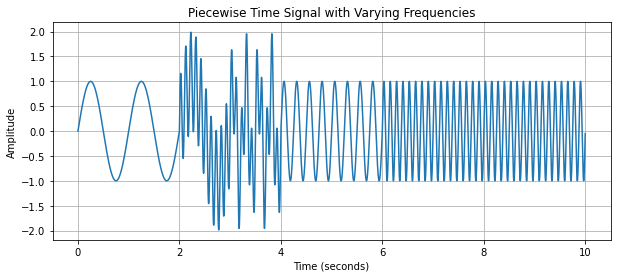

[ 1.          1.04712855  1.0964782   1.14815362  1.20226443  1.25892541
  1.31825674  1.38038426  1.44543977  1.51356125  1.58489319  1.65958691
  1.73780083  1.81970086  1.90546072  1.99526231  2.08929613  2.18776162
  2.29086765  2.39883292  2.51188643  2.63026799  2.7542287   2.8840315
  3.01995172  3.16227766  3.31131121  3.4673685   3.63078055  3.80189396
  3.98107171  4.16869383  4.36515832  4.5708819   4.78630092  5.01187234
  5.2480746   5.49540874  5.75439937  6.02559586  6.30957344  6.60693448
  6.91830971  7.2443596   7.58577575  7.94328235  8.31763771  8.7096359
  9.12010839  9.54992586 10.        ]


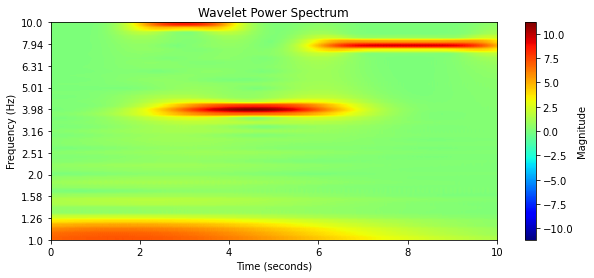

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Define the duration of the signal and the sampling rate
duration = 10
sampling_rate = 1000
freqs = [1, 4, 8, 10]
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define a lambda function for creating piecewise components of the signal
signal_piecewise = lambda start, end, freq: np.sin(2 * np.pi * freq * t) * np.logical_and(t > start, t < end)

# Generate the piecewise signal
signal = np.zeros_like(t)
signal += signal_piecewise(0, 0.3 * duration, freqs[0])
signal += signal_piecewise(0.3 * duration, 0.6 * duration, freqs[1])
signal += signal_piecewise(0.6 * duration, duration, freqs[2])
signal += signal_piecewise(0.2 * duration, 0.4 * duration, freqs[3])

# Plot the generated signal
plt.figure(figsize=(10, 4))
plt.plot(t, signal)
plt.title('Piecewise Time Signal with Varying Frequencies')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

#######################################################################################################################

# Given values for fmin, fmax, and f0
fmin = 1  # Minimum frequency
fmax = 10  # Maximum frequency
f0 = 3    # Center frequency for the Morlet wavelet
num_freqs = 100
wvlt_freqs = np.logspace(fmin, fmax, num_freqs)

# Find scales
base_freq = fmin  # Determines bottom range of frequencies 
base_scale = f0 * sampling_rate / base_freq
num_octaves = 10  # More octaves = larger range of scales to analyze
voices_per_octave = 5  # More voices means more signals to analyze = more scales = more resolution
# far_scale = base_scale / 2**num_octaves  # Written with powers of 2 due to doubling of frequency per octave!!  (Determines top range of frequencies)
far_scale = base_scale / fmax  # Written with powers of 2 due to doubling of frequency per octave!!  (Determines top range of frequencies)

scales = np.geomspace(base_scale, far_scale, num=num_octaves*voices_per_octave+1, endpoint=True)

#######################################################################################################################

C = f0
B = (C**2) / 2

# Now let's perform the wavelet transform using PyWavelets
wavelet_name = 'cmor' + str(B) + '-' + str(C)

# Perform the Continuous Wavelet Transform (CWT)
coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)

print(frequencies)

y_tick_indices = np.linspace(0, len(frequencies) - 1, 10, dtype=int)
y_tick_labels = frequencies[y_tick_indices]

# Plot the wavelet power spectrum
fig, ax = plt.subplots(figsize=(10, 4))

# Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))

# Plot the image with y-axis values ranging from 0 to len(frequencies) - 1
extent = [0, duration, 0, len(frequencies) - 1]
im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

# Set the y-ticks to correspond to the positions we just created
ax.set_yticks(y_positions[::len(y_positions) // 10])

# Set the y-tick labels to show the frequency values
ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])

# Add the rest of your plot details
ax.set_title('Wavelet Power Spectrum')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency (Hz)')

# Add a colorbar for the magnitude
fig.colorbar(im, ax=ax, label='Magnitude')

plt.show()

# Add Visualization. Figure Out Scales and Frequencies

c:\Users\chris\anaconda3\lib\site-packages\pywt\_functions.py:142: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


pywt.central_frequency =  0.5
pywt.central_frequency =  3.0


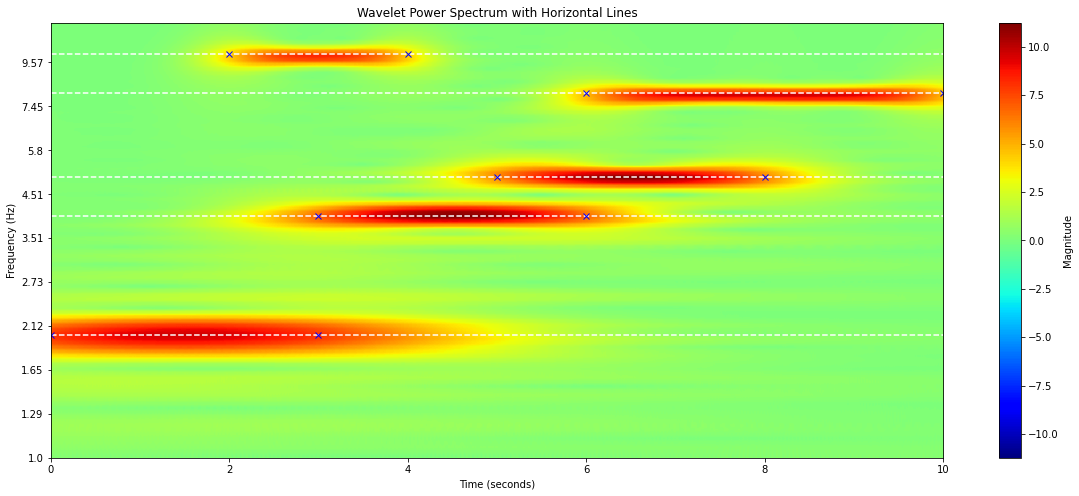

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Define the duration of the signal and the sampling rate
duration = 10
sampling_rate = 1000
freqs = [2, 4, 5, 8, 10]
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define a lambda function for creating piecewise components of the signal
signal_piecewise = lambda start, end, freq: np.sin(2 * np.pi * freq * t) * np.logical_and(t > start, t < end)

# Generate the piecewise signal
signal = np.zeros_like(t)
signal += signal_piecewise(0, 0.3 * duration, freqs[0])
signal += signal_piecewise(0.3 * duration, 0.6 * duration, freqs[1])
signal += signal_piecewise(0.5 * duration, 0.8 * duration, freqs[2])
signal += signal_piecewise(0.6 * duration, duration, freqs[3])
signal += signal_piecewise(0.2 * duration, 0.4 * duration, freqs[4])

# Given values for fmin, fmax, and f0
fmin = 1  # Minimum frequency
fmax = 12  # Maximum frequency
f0 = 3    # Center frequency for the Morlet wavelet
resolution = 100  # Resolution of frequencies/scales

# Find scales
base_freq = fmin  # Determines bottom range of frequencies 
base_scale = f0 * sampling_rate / base_freq
far_scale = base_scale / fmax 
scales = np.geomspace(base_scale, far_scale, num=resolution, endpoint=True)

# Parameters of Wavelet Transformation
C = f0
B = (C**2) / 2

# Perform the Continuous Wavelet Transform (CWT) using PyWavelets
wavelet_name = 'cmor' + str(B) + '-' + str(C)
coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)


print('pywt.central_frequency = ', pywt.central_frequency('cmor'))
print('pywt.central_frequency = ', pywt.central_frequency(wavelet_name))

# Plot the wavelet power spectrum with horizontal lines at the given 'freqs' values
fig, ax = plt.subplots(figsize=(20, 8))

extent = [0, duration, 0, len(frequencies) - 1]  # Plot the image with y-axis values ranging from 0 to len(frequencies) - 1
im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))  # Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
ax.set_yticks(y_positions[::len(y_positions) // 10])  # Set the y-ticks to correspond to the positions we just created
ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])  # Set the y-tick labels to show the frequency values

ax.set_title('Wavelet Power Spectrum with Horizontal Lines')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency (Hz)')
fig.colorbar(im, ax=ax, label='Magnitude')

# Add horizontal lines at the positions corresponding to the 'freqs'
for freq in freqs:  # Get the indices of the horizontal lines for the wavelet transformation
    idx = (np.abs(frequencies - freq)).argmin()  # Find the closest frequency in the 'frequencies' array and get its index
    plt.axhline(y=idx, color='white', linestyle='--')

# Define the start and end points for each frequency component
freq_components = [
    (0, 0.3 * duration, freqs[0]),
    (0.3 * duration, 0.6 * duration, freqs[1]),
    (0.5 * duration, 0.8 * duration, freqs[2]),
    (0.6 * duration, duration, freqs[3]),
    (0.2 * duration, 0.4 * duration, freqs[4])
]
# Add markers for the start and end of each frequency component
for start, end, freq in freq_components:
    # Get the y-position for the marker corresponding to the frequency
    y_position = (np.abs(frequencies - freq)).argmin()
    # Plot the start marker
    plt.plot(start, y_position, 'bx')  # Blue x marker
    # Plot the end marker
    plt.plot(end, y_position, 'bx')  # Blue x marker

plt.show()


# Change the code above to a function (Need to Update)

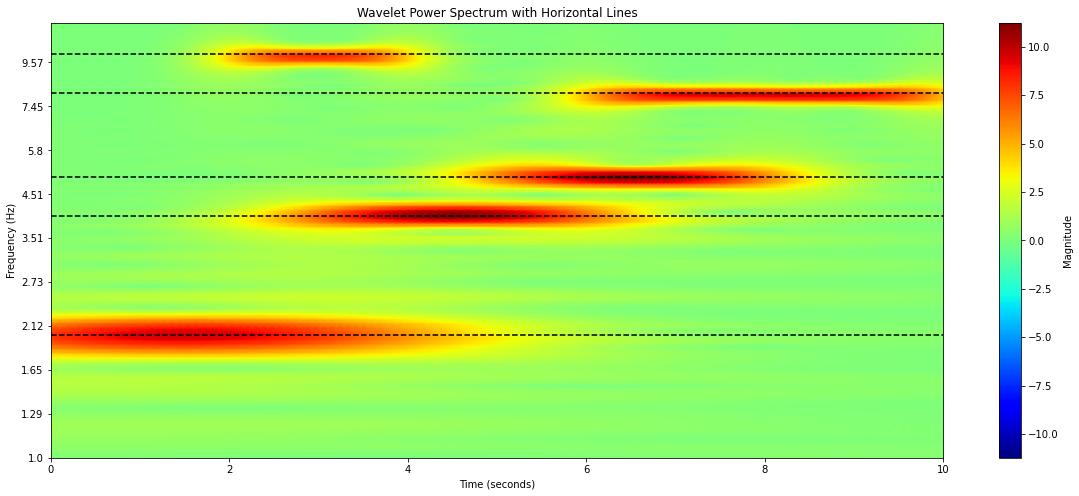

In [ ]:
def perform_cwt(signal = signal, freqs = [2, 4, 5, 8, 10], fmin = 1, fmax = 12, f0 = 3, freq_resolution = 100, sampling_rate = 1000):
    # Find scales
    base_freq = fmin  # Determines bottom range of frequencies 
    base_scale = f0 * sampling_rate / base_freq
    far_scale = base_scale / fmax 
    scales = np.geomspace(base_scale, far_scale, num=freq_resolution, endpoint=True)

    # Parameters of Wavelet Transformation
    C = f0
    B = (C**2) / 2

    # Perform the Continuous Wavelet Transform (CWT) using PyWavelets
    wavelet_name = 'cmor' + str(B) + '-' + str(C)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)

    # Plot the wavelet power spectrum with horizontal lines at the given 'freqs' values
    fig, ax = plt.subplots(figsize=(20, 8))

    extent = [0, duration, 0, len(frequencies) - 1]  # Plot the image with y-axis values ranging from 0 to len(frequencies) - 1
    im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

    y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))  # Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
    ax.set_yticks(y_positions[::len(y_positions) // 10])  # Set the y-ticks to correspond to the positions we just created
    ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])  # Set the y-tick labels to show the frequency values

    ax.set_title('Wavelet Power Spectrum with Horizontal Lines')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, label='Magnitude')

    # Add horizontal lines at the positions corresponding to the 'freqs'
    for freq in freqs:  # Get the indices of the horizontal lines for the wavelet transformation
        idx = (np.abs(frequencies - freq)).argmin()  # Find the closest frequency in the 'frequencies' array and get its index
        plt.axhline(y=idx, color='black', linestyle='--')

    plt.show()

perform_cwt()

# Need to figure out the units. Change the frequencies to accomodate a larger range (different units).

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

f0s = [3,4,5, 10, 20, 50, 100, 1000]
for f0 in f0s:
    # Adjusted frequencies (in Hz)
    freqs = [100, 1000, 4000, 10000, 20000]

    # Duration and adjusted sampling rate
    duration = 10
    sampling_rate = 50000  # Increased sampling rate to accommodate higher frequencies
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    # Define a lambda function for creating piecewise components of the signal
    signal_piecewise = lambda start, end, freq: np.sin(2 * np.pi * freq * t) * np.logical_and(t > start, t < end)

    # Generate the piecewise signal
    signal = np.zeros_like(t)
    signal += signal_piecewise(0, 0.3 * duration, freqs[0])
    signal += signal_piecewise(0.3 * duration, 0.6 * duration, freqs[1])
    signal += signal_piecewise(0.5 * duration, 0.8 * duration, freqs[2])
    signal += signal_piecewise(0.6 * duration, duration, freqs[3])
    signal += signal_piecewise(0.2 * duration, 0.4 * duration, freqs[4])

    # Frequency and scale adjustments
    fmin = 100  # Minimum frequency in Hz
    fmax = 20000  # Maximum frequency in Hz
    f0 = f0  # Central frequency of the Morlet wavelet, unchanged  #TODO: CHANGE
    resolution = 100  # Resolution of scales, unchanged

    # Recalculate scales
    base_freq = fmin
    base_scale = f0 * sampling_rate / base_freq
    far_scale = base_scale / fmax
    scales = np.geomspace(base_scale, far_scale, num=resolution, endpoint=True)

    # Parameters of Wavelet Transformation
    C = f0
    B = (C**2) / 2

    # Perform the Continuous Wavelet Transform (CWT) using PyWavelets
    wavelet_name = 'cmor' + str(B) + '-' + str(C)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)

    print('pywt.central_frequency = ', pywt.central_frequency('cmor'))
    print('pywt.central_frequency = ', pywt.central_frequency(wavelet_name))

    # Plot the wavelet power spectrum with horizontal lines at the given 'freqs' values
    fig, ax = plt.subplots(figsize=(20, 8))

    extent = [0, duration, 0, len(frequencies) - 1]  # Plot the image with y-axis values ranging from 0 to len(frequencies) - 1
    im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

    y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))  # Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
    ax.set_yticks(y_positions[::len(y_positions) // 10])  # Set the y-ticks to correspond to the positions we just created
    ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])  # Set the y-tick labels to show the frequency values

    ax.set_title('Wavelet Power Spectrum with Horizontal Lines')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, label='Magnitude')

    # Add horizontal lines at the positions corresponding to the 'freqs'
    for freq in freqs:  # Get the indices of the horizontal lines for the wavelet transformation
        idx = (np.abs(frequencies - freq)).argmin()  # Find the closest frequency in the 'frequencies' array and get its index
        plt.axhline(y=idx, color='white', linestyle='--')

    # Define the start and end points for each frequency component
    freq_components = [
        (0, 0.3 * duration, freqs[0]),
        (0.3 * duration, 0.6 * duration, freqs[1]),
        (0.5 * duration, 0.8 * duration, freqs[2]),
        (0.6 * duration, duration, freqs[3]),
        (0.2 * duration, 0.4 * duration, freqs[4])
    ]
    # Add markers for the start and end of each frequency component
    for start, end, freq in freq_components:
        # Get the y-position for the marker corresponding to the frequency
        y_position = (np.abs(frequencies - freq)).argmin()
        # Plot the start marker
        plt.plot(start, y_position, 'bx')  # Blue x marker
        # Plot the end marker
        plt.plot(end, y_position, 'bx')  # Blue x marker

    plt.show()

c:\Users\chris\anaconda3\lib\site-packages\pywt\_functions.py:142: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


pywt.central_frequency =  0.5
pywt.central_frequency =  3.0


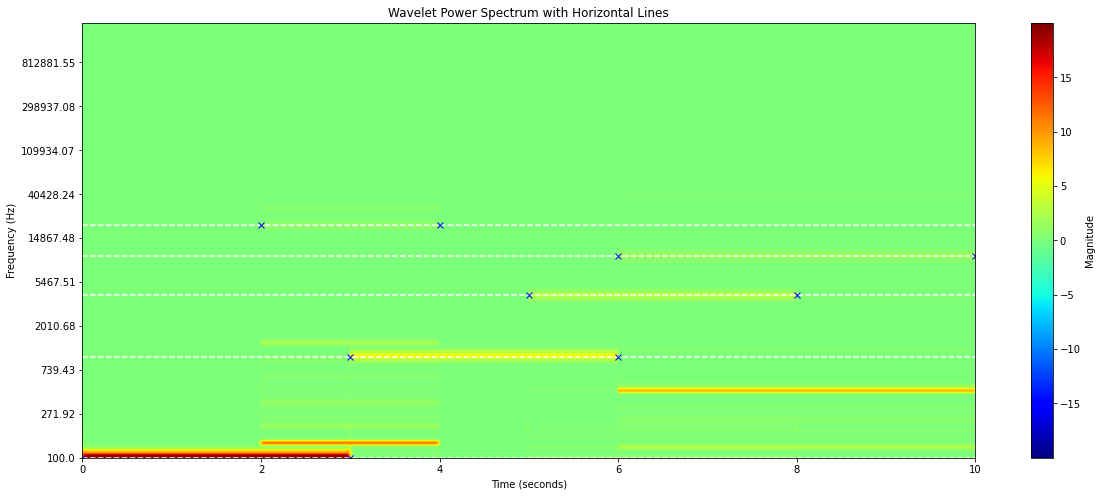

pywt.central_frequency =  0.5
pywt.central_frequency =  3.0


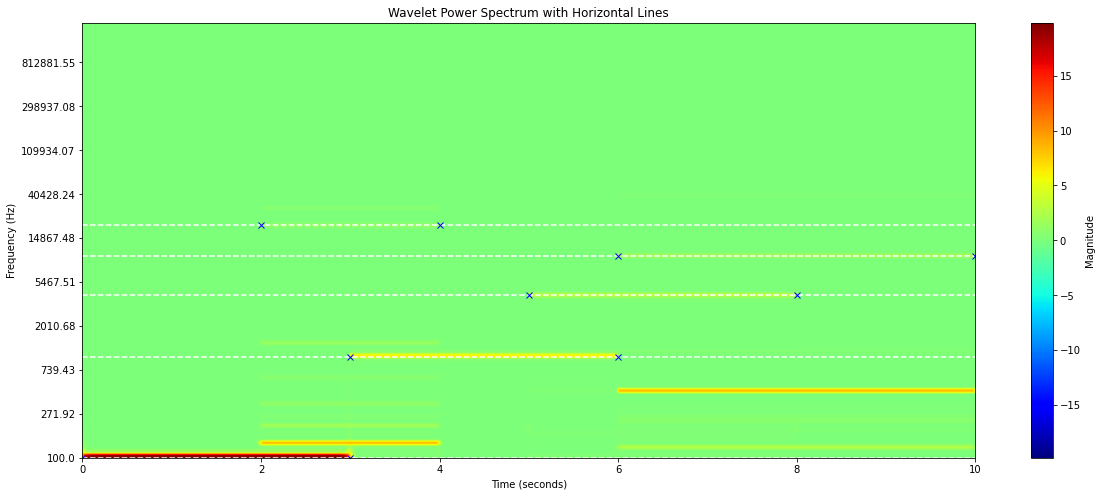

pywt.central_frequency =  0.5
pywt.central_frequency =  3.0


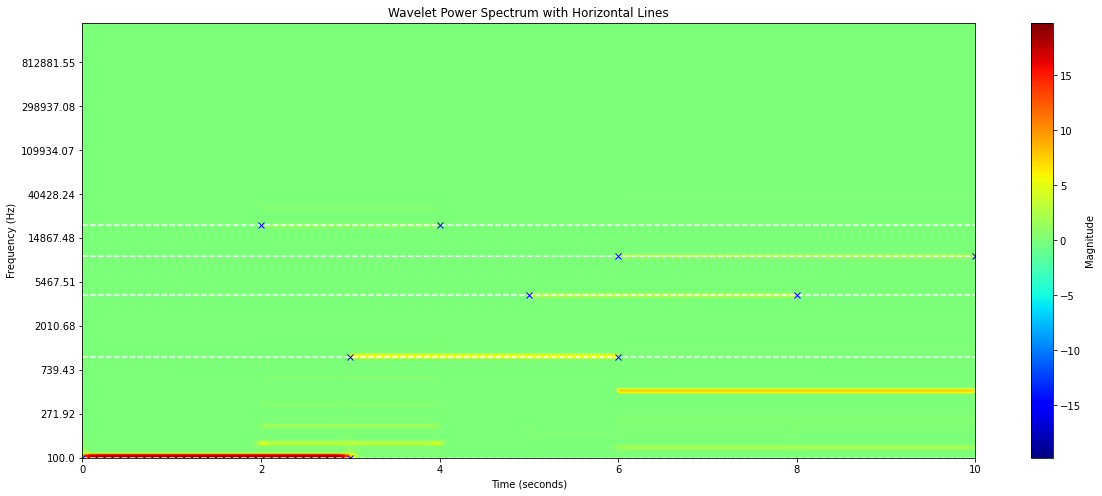

pywt.central_frequency =  0.5
pywt.central_frequency =  3.0


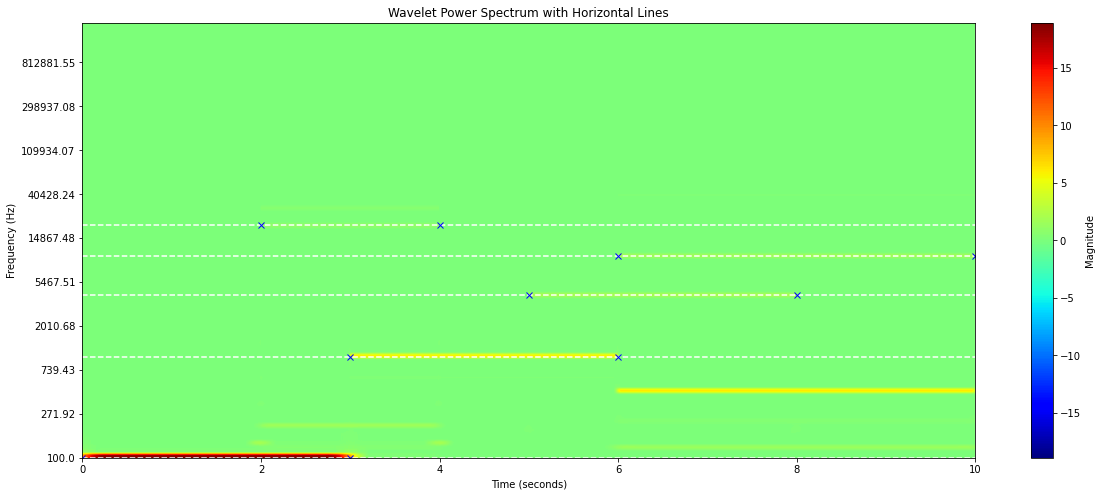

pywt.central_frequency =  0.5
pywt.central_frequency =  3.0


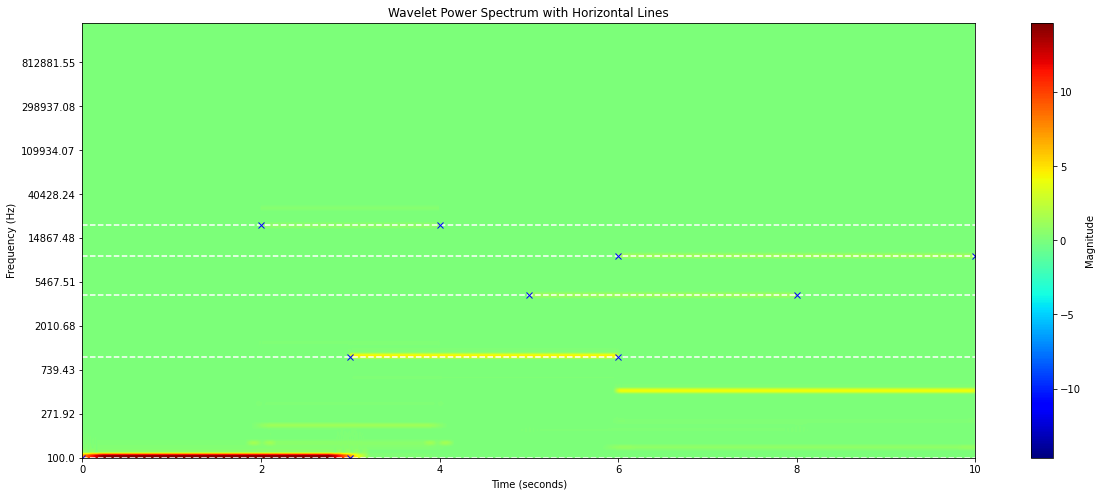

In [7]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Adjusted frequencies (in Hz)
freqs = [100, 1000, 4000, 10000, 20000]

# Duration and adjusted sampling rate
duration = 10
sampling_rate = 50000  # Increased sampling rate to accommodate higher frequencies
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define a lambda function for creating piecewise components of the signal
signal_piecewise = lambda start, end, freq: np.sin(2 * np.pi * freq * t) * np.logical_and(t > start, t < end)

# Generate the piecewise signal
signal = np.zeros_like(t)
signal += signal_piecewise(0, 0.3 * duration, freqs[0])
signal += signal_piecewise(0.3 * duration, 0.6 * duration, freqs[1])
signal += signal_piecewise(0.5 * duration, 0.8 * duration, freqs[2])
signal += signal_piecewise(0.6 * duration, duration, freqs[3])
signal += signal_piecewise(0.2 * duration, 0.4 * duration, freqs[4])

Bs = np.logspace(0, 2, 5)
for B in Bs:

    # Frequency and scale adjustments
    fmin = 100  # Minimum frequency in Hz
    fmax = 20000  # Maximum frequency in Hz
    f0 = 3  # Central frequency of the Morlet wavelet, unchanged  #TODO: CHANGE
    resolution = 100  # Resolution of scales, unchanged

    # Recalculate scales
    base_freq = fmin
    base_scale = f0 * sampling_rate / base_freq
    far_scale = base_scale / fmax
    scales = np.geomspace(base_scale, far_scale, num=resolution, endpoint=True)

    # Parameters of Wavelet Transformation
    C = f0
    # B = (C**2) / 2
    B = B

    # Perform the Continuous Wavelet Transform (CWT) using PyWavelets
    wavelet_name = 'cmor' + str(B) + '-' + str(C)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)

    print('pywt.central_frequency = ', pywt.central_frequency('cmor'))
    print('pywt.central_frequency = ', pywt.central_frequency(wavelet_name))

    # Plot the wavelet power spectrum with horizontal lines at the given 'freqs' values
    fig, ax = plt.subplots(figsize=(20, 8))

    extent = [0, duration, 0, len(frequencies) - 1]  # Plot the image with y-axis values ranging from 0 to len(frequencies) - 1
    im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

    y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))  # Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
    ax.set_yticks(y_positions[::len(y_positions) // 10])  # Set the y-ticks to correspond to the positions we just created
    ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])  # Set the y-tick labels to show the frequency values

    ax.set_title('Wavelet Power Spectrum with Horizontal Lines')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, label='Magnitude')

    # Add horizontal lines at the positions corresponding to the 'freqs'
    for freq in freqs:  # Get the indices of the horizontal lines for the wavelet transformation
        idx = (np.abs(frequencies - freq)).argmin()  # Find the closest frequency in the 'frequencies' array and get its index
        plt.axhline(y=idx, color='white', linestyle='--')

    # Define the start and end points for each frequency component
    freq_components = [
        (0, 0.3 * duration, freqs[0]),
        (0.3 * duration, 0.6 * duration, freqs[1]),
        (0.5 * duration, 0.8 * duration, freqs[2]),
        (0.6 * duration, duration, freqs[3]),
        (0.2 * duration, 0.4 * duration, freqs[4])
    ]
    # Add markers for the start and end of each frequency component
    for start, end, freq in freq_components:
        # Get the y-position for the marker corresponding to the frequency
        y_position = (np.abs(frequencies - freq)).argmin()
        # Plot the start marker
        plt.plot(start, y_position, 'bx')  # Blue x marker
        # Plot the end marker
        plt.plot(end, y_position, 'bx')  # Blue x marker

    plt.show()

pywt.central_frequency =  0.5
pywt.central_frequency =  3.0


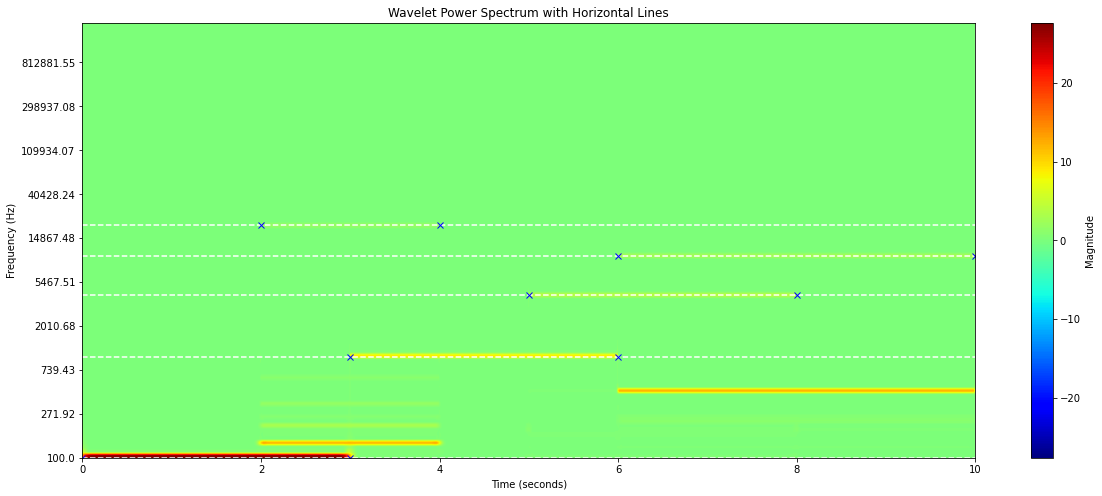

In [9]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# Adjusted frequencies (in Hz)
freqs = [100, 1000, 4000, 10000, 20000]

# Duration and adjusted sampling rate
duration = 10
sampling_rate = 100000  # Increased sampling rate to accommodate higher frequencies
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define a lambda function for creating piecewise components of the signal
signal_piecewise = lambda start, end, freq: np.sin(2 * np.pi * freq * t) * np.logical_and(t > start, t < end)

# Generate the piecewise signal
signal = np.zeros_like(t)
signal += signal_piecewise(0, 0.3 * duration, freqs[0])
signal += signal_piecewise(0.3 * duration, 0.6 * duration, freqs[1])
signal += signal_piecewise(0.5 * duration, 0.8 * duration, freqs[2])
signal += signal_piecewise(0.6 * duration, duration, freqs[3])
signal += signal_piecewise(0.2 * duration, 0.4 * duration, freqs[4])

Bs = [3**2/2]
for B in Bs:

    # Frequency and scale adjustments
    fmin = 100  # Minimum frequency in Hz
    fmax = 20000  # Maximum frequency in Hz
    f0 = 3  # Central frequency of the Morlet wavelet, unchanged  #TODO: CHANGE
    resolution = 100  # Resolution of scales, unchanged

    # Recalculate scales
    base_freq = fmin
    base_scale = f0 * sampling_rate / base_freq
    far_scale = base_scale / fmax
    scales = np.geomspace(base_scale, far_scale, num=resolution, endpoint=True)

    # Parameters of Wavelet Transformation
    C = f0
    # B = (C**2) / 2
    B = B

    # Perform the Continuous Wavelet Transform (CWT) using PyWavelets
    wavelet_name = 'cmor' + str(B) + '-' + str(C)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)

    print('pywt.central_frequency = ', pywt.central_frequency('cmor'))
    print('pywt.central_frequency = ', pywt.central_frequency(wavelet_name))

    # Plot the wavelet power spectrum with horizontal lines at the given 'freqs' values
    fig, ax = plt.subplots(figsize=(20, 8))

    extent = [0, duration, 0, len(frequencies) - 1]  # Plot the image with y-axis values ranging from 0 to len(frequencies) - 1
    im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

    y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))  # Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
    ax.set_yticks(y_positions[::len(y_positions) // 10])  # Set the y-ticks to correspond to the positions we just created
    ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])  # Set the y-tick labels to show the frequency values

    ax.set_title('Wavelet Power Spectrum with Horizontal Lines')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, label='Magnitude')

    # Add horizontal lines at the positions corresponding to the 'freqs'
    for freq in freqs:  # Get the indices of the horizontal lines for the wavelet transformation
        idx = (np.abs(frequencies - freq)).argmin()  # Find the closest frequency in the 'frequencies' array and get its index
        plt.axhline(y=idx, color='white', linestyle='--')

    # Define the start and end points for each frequency component
    freq_components = [
        (0, 0.3 * duration, freqs[0]),
        (0.3 * duration, 0.6 * duration, freqs[1]),
        (0.5 * duration, 0.8 * duration, freqs[2]),
        (0.6 * duration, duration, freqs[3]),
        (0.2 * duration, 0.4 * duration, freqs[4])
    ]
    # Add markers for the start and end of each frequency component
    for start, end, freq in freq_components:
        # Get the y-position for the marker corresponding to the frequency
        y_position = (np.abs(frequencies - freq)).argmin()
        # Plot the start marker
        plt.plot(start, y_position, 'bx')  # Blue x marker
        # Plot the end marker
        plt.plot(end, y_position, 'bx')  # Blue x marker

    plt.show()

              Datetime  PJM_Load_MW
0  1998-12-31 01:00:00      29309.0
1  1998-12-31 02:00:00      28236.0
2  1998-12-31 03:00:00      27692.0
3  1998-12-31 04:00:00      27596.0
4  1998-12-31 05:00:00      27888.0


Text(0.5, 0, 'Year')

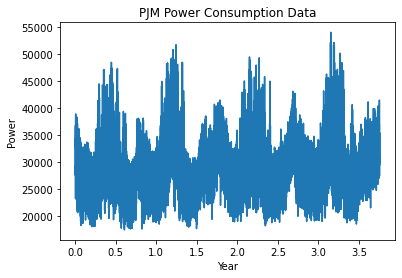

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the duration of the signal and the sampling rate
signal = pd.read_csv('PJM_Load_hourly.csv')
print(signal.head())
signal = signal["PJM_Load_MW"]
signal = np.array(signal)

dataLength = len(signal)
numHours = dataLength
numHourPerDay = 24
numDayPerYear = 365

t = np.linspace(0, numHours/(numHourPerDay*numDayPerYear), numHours)

plt.figure()
plt.plot(t, signal)
plt.title('PJM Power Consumption Data')
plt.ylabel('Power')
plt.xlabel('Year')


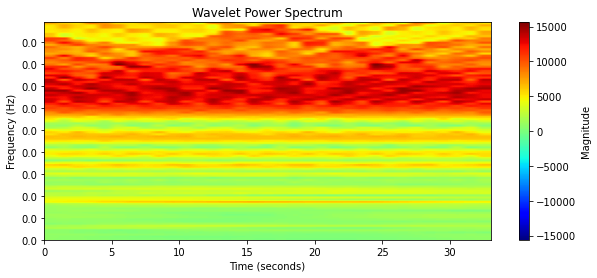

In [ ]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

signal = signal[:5000]

sampling_rate = 1/(10*6*24)
duration = len(signal)
#######################################################################################################################

# Given values for fmin, fmax, and f0
fmin = 1/1440  # Minimum frequency
fmax = 1/720  # Maximum frequency
f0 = 3    # Center frequency for the Morlet wavelet
num_freqs = 100
wvlt_freqs = np.logspace(fmin, fmax, num_freqs)

# Find scales
base_freq = fmin  # Determines bottom range of frequencies 
base_scale = f0 * sampling_rate / base_freq
num_octaves = 10  # More octaves = larger range of scales to analyze
voices_per_octave = 5  # More voices means more signals to analyze = more scales = more resolution
# far_scale = base_scale / 2**num_octaves  # Written with powers of 2 due to doubling of frequency per octave!!  (Determines top range of frequencies)
far_scale = base_scale / fmax  # Written with powers of 2 due to doubling of frequency per octave!!  (Determines top range of frequencies)

scales = np.geomspace(base_scale, far_scale, num=100, endpoint=True)

#######################################################################################################################

C = f0
B = (C**2) / 2

# Now let's perform the wavelet transform using PyWavelets
wavelet_name = 'cmor' + str(B) + '-' + str(C)

# Perform the Continuous Wavelet Transform (CWT)
coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)

fig, ax = plt.subplots(figsize=(10, 4))

# Create an array of y positions from 0 to the number of frequencies, this will be the new y-axis
y_positions = np.linspace(start=0, stop=len(frequencies) - 1, num=len(frequencies))

# Plot the image with y-axis values ranging from 0 to len(frequencies) - 1
extent = [0, duration, 0, len(frequencies) - 1]
im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

# Set the y-ticks to correspond to the positions we just created
ax.set_yticks(y_positions[::len(y_positions) // 10])

# Set the y-tick labels to show the frequency values
ax.set_yticklabels(np.round(frequencies, decimals=2)[::len(y_positions) // 10])

# Add the rest of your plot details
ax.set_title('Wavelet Power Spectrum')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Frequency (Hz)')

# Add a colorbar for the magnitude
fig.colorbar(im, ax=ax, label='Magnitude')

plt.show()

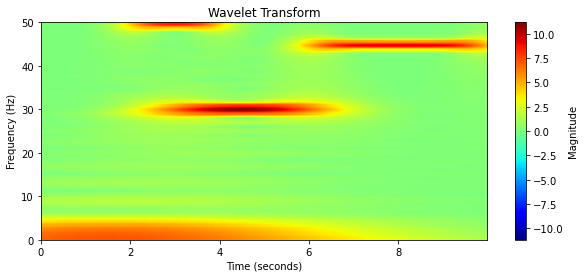

In [ ]:
# TURN INTO A METHOD
import pywt
import matplotlib.pyplot as plt
import numpy as np

def perform_wavelet_transform(signal, t, fmin=1, fmax=10, f0=3, num_freqs=100, num_octaves=10, voices_per_octave=5, title='Wavelet Transform'):
    sampling_rate = 1 / (t[1] - t[0])
    # Calculate scales for wavelet transform
    base_scale = f0 * sampling_rate / fmin
    far_scale = base_scale / fmax
    scales = np.geomspace(base_scale, far_scale, num=num_octaves*voices_per_octave+1, endpoint=True)

    C = f0
    B = (C**2) / 2
    wavelet_name = 'cmor' + str(B) + '-' + str(C)
    
    # Perform the Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet_name, 1 / sampling_rate)
    
    # Plot the wavelet power spectrum
    fig, ax = plt.subplots(figsize=(10, 4))
    extent = [0, t[-1], 0, len(frequencies) - 1]
    im = ax.imshow(np.abs(coefficients), extent=extent, cmap='jet', aspect='auto', origin='lower', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
    ax.set_title(title)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, label='Magnitude')
    plt.show()

# Define your example signal parameters
duration = 10
sampling_rate = 1000
freqs = [1, 4, 8, 10]
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Define a lambda function for creating piecewise components of the signal
signal_piecewise = lambda start, end, freq: np.sin(2 * np.pi * freq * t) * np.logical_and(t > start, t < end)

# Generate the piecewise signal
signal = np.zeros_like(t)
signal += signal_piecewise(0, 0.3 * duration, freqs[0])
signal += signal_piecewise(0.3 * duration, 0.6 * duration, freqs[1])
signal += signal_piecewise(0.6 * duration, duration, freqs[2])
signal += signal_piecewise(0.2 * duration, 0.4 * duration, freqs[3])

# Now, run the method with the example signal
perform_wavelet_transform(signal, t)

#TODO: FIX Y AXIS
